In [ ]:
from IPython.display import Markdown
import json
import math
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sympy import (
    Add,
    Derivative,
    Expr,
    eye,
    Function,
    Indexed,
    IndexedBase,
    latex,
    Matrix,
    Mul,
    simplify,
    Symbol,
    symbols,
)
from sympy.physics.quantum import TensorProduct
import torch
import torch.nn as nn
from torch.nn import functional as F
from typing import Iterable, Tuple

# SymPy simulation of attention head

In [ ]:
# Helpers that really ought to be in a shared lib
def ndarray_of_indexed_base(
    ib: IndexedBase, shape: Tuple[int, int], transform=lambda x: x
) -> np.ndarray:
    rows, cols = shape
    data = [
        [transform(ib[i, j]) for j in range(1, cols + 1)] for i in range(1, rows + 1)
    ]
    return np.array(data, dtype=object)

def matrix_to_markdown(matrix: np.ndarray) -> str:
    h, w = matrix.shape
    elements = (r'\\' + '\n').join(
        [' & '.join([latex(matrix[i][j]) for j in range(w)]) for i in range(h)]
    )

    markdown = '$$' r'\begin{bmatrix}' + '\n' + elements + r'\end{bmatrix}' + '\n' '$$'
    return markdown

latex_ufunc = np.frompyfunc(latex, 1, 1)

In [ ]:
sim_n_embed = 4
sim_head_size = 3
sim_block_size = 2 

Wq = ndarray_of_indexed_base(IndexedBase('Wq'), (sim_n_embed, sim_head_size))
Wk = ndarray_of_indexed_base(IndexedBase('Wk'), (sim_n_embed, sim_head_size))
Wv = ndarray_of_indexed_base(IndexedBase('Wv'), (sim_n_embed, sim_head_size))

X = ndarray_of_indexed_base(IndexedBase('X'), (sim_block_size, sim_n_embed))

k = X @ Wk
q = X @ Wq
v = X @ Wv

attn = (1 / math.sqrt(sim_head_size)) * (k @ q.T) @ v 

Markdown(matrix_to_markdown(attn))


$$\begin{bmatrix}
\left(0.577350269189626 \left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,1} {X}_{1,1} + {Wv}_{2,1} {X}_{1,2} + {Wv}_{3,1} {X}_{1,3} + {Wv}_{4,1} {X}_{1,4}\right) + \left(0.577350269189626 \left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{2,1} + {Wq}_{2,2} {X}_{2,2} + {Wq}_{3,2} {X}_{2,3} + {Wq}_{4,2} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{2,1} + {Wq}_{2,3} {X}_{2,2} + {Wq}_{3,3} {X}_{2,3} + {Wq}_{4,3} {X}_{2,4}\right)\right) \left({Wv}_{1,1} {X}_{2,1} + {Wv}_{2,1} {X}_{2,2} + {Wv}_{3,1} {X}_{2,3} + {Wv}_{4,1} {X}_{2,4}\right) & \left(0.577350269189626 \left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,2} {X}_{1,1} + {Wv}_{2,2} {X}_{1,2} + {Wv}_{3,2} {X}_{1,3} + {Wv}_{4,2} {X}_{1,4}\right) + \left(0.577350269189626 \left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{2,1} + {Wq}_{2,2} {X}_{2,2} + {Wq}_{3,2} {X}_{2,3} + {Wq}_{4,2} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{2,1} + {Wq}_{2,3} {X}_{2,2} + {Wq}_{3,3} {X}_{2,3} + {Wq}_{4,3} {X}_{2,4}\right)\right) \left({Wv}_{1,2} {X}_{2,1} + {Wv}_{2,2} {X}_{2,2} + {Wv}_{3,2} {X}_{2,3} + {Wv}_{4,2} {X}_{2,4}\right) & \left(0.577350269189626 \left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,3} {X}_{1,1} + {Wv}_{2,3} {X}_{1,2} + {Wv}_{3,3} {X}_{1,3} + {Wv}_{4,3} {X}_{1,4}\right) + \left(0.577350269189626 \left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{2,1} + {Wq}_{2,2} {X}_{2,2} + {Wq}_{3,2} {X}_{2,3} + {Wq}_{4,2} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{2,1} + {Wq}_{2,3} {X}_{2,2} + {Wq}_{3,3} {X}_{2,3} + {Wq}_{4,3} {X}_{2,4}\right)\right) \left({Wv}_{1,3} {X}_{2,1} + {Wv}_{2,3} {X}_{2,2} + {Wv}_{3,3} {X}_{2,3} + {Wv}_{4,3} {X}_{2,4}\right)\\
\left(0.577350269189626 \left({Wk}_{1,1} {X}_{2,1} + {Wk}_{2,1} {X}_{2,2} + {Wk}_{3,1} {X}_{2,3} + {Wk}_{4,1} {X}_{2,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{2,1} + {Wk}_{2,2} {X}_{2,2} + {Wk}_{3,2} {X}_{2,3} + {Wk}_{4,2} {X}_{2,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{2,1} + {Wk}_{2,3} {X}_{2,2} + {Wk}_{3,3} {X}_{2,3} + {Wk}_{4,3} {X}_{2,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,1} {X}_{1,1} + {Wv}_{2,1} {X}_{1,2} + {Wv}_{3,1} {X}_{1,3} + {Wv}_{4,1} {X}_{1,4}\right) + \left(0.577350269189626 \left({Wk}_{1,1} {X}_{2,1} + {Wk}_{2,1} {X}_{2,2} + {Wk}_{3,1} {X}_{2,3} + {Wk}_{4,1} {X}_{2,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{2,1} + {Wk}_{2,2} {X}_{2,2} + {Wk}_{3,2} {X}_{2,3} + {Wk}_{4,2} {X}_{2,4}\right) \left({Wq}_{1,2} {X}_{2,1} + {Wq}_{2,2} {X}_{2,2} + {Wq}_{3,2} {X}_{2,3} + {Wq}_{4,2} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{2,1} + {Wk}_{2,3} {X}_{2,2} + {Wk}_{3,3} {X}_{2,3} + {Wk}_{4,3} {X}_{2,4}\right) \left({Wq}_{1,3} {X}_{2,1} + {Wq}_{2,3} {X}_{2,2} + {Wq}_{3,3} {X}_{2,3} + {Wq}_{4,3} {X}_{2,4}\right)\right) \left({Wv}_{1,1} {X}_{2,1} + {Wv}_{2,1} {X}_{2,2} + {Wv}_{3,1} {X}_{2,3} + {Wv}_{4,1} {X}_{2,4}\right) & \left(0.577350269189626 \left({Wk}_{1,1} {X}_{2,1} + {Wk}_{2,1} {X}_{2,2} + {Wk}_{3,1} {X}_{2,3} + {Wk}_{4,1} {X}_{2,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{2,1} + {Wk}_{2,2} {X}_{2,2} + {Wk}_{3,2} {X}_{2,3} + {Wk}_{4,2} {X}_{2,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{2,1} + {Wk}_{2,3} {X}_{2,2} + {Wk}_{3,3} {X}_{2,3} + {Wk}_{4,3} {X}_{2,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,2} {X}_{1,1} + {Wv}_{2,2} {X}_{1,2} + {Wv}_{3,2} {X}_{1,3} + {Wv}_{4,2} {X}_{1,4}\right) + \left(0.577350269189626 \left({Wk}_{1,1} {X}_{2,1} + {Wk}_{2,1} {X}_{2,2} + {Wk}_{3,1} {X}_{2,3} + {Wk}_{4,1} {X}_{2,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{2,1} + {Wk}_{2,2} {X}_{2,2} + {Wk}_{3,2} {X}_{2,3} + {Wk}_{4,2} {X}_{2,4}\right) \left({Wq}_{1,2} {X}_{2,1} + {Wq}_{2,2} {X}_{2,2} + {Wq}_{3,2} {X}_{2,3} + {Wq}_{4,2} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{2,1} + {Wk}_{2,3} {X}_{2,2} + {Wk}_{3,3} {X}_{2,3} + {Wk}_{4,3} {X}_{2,4}\right) \left({Wq}_{1,3} {X}_{2,1} + {Wq}_{2,3} {X}_{2,2} + {Wq}_{3,3} {X}_{2,3} + {Wq}_{4,3} {X}_{2,4}\right)\right) \left({Wv}_{1,2} {X}_{2,1} + {Wv}_{2,2} {X}_{2,2} + {Wv}_{3,2} {X}_{2,3} + {Wv}_{4,2} {X}_{2,4}\right) & \left(0.577350269189626 \left({Wk}_{1,1} {X}_{2,1} + {Wk}_{2,1} {X}_{2,2} + {Wk}_{3,1} {X}_{2,3} + {Wk}_{4,1} {X}_{2,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{2,1} + {Wk}_{2,2} {X}_{2,2} + {Wk}_{3,2} {X}_{2,3} + {Wk}_{4,2} {X}_{2,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{2,1} + {Wk}_{2,3} {X}_{2,2} + {Wk}_{3,3} {X}_{2,3} + {Wk}_{4,3} {X}_{2,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,3} {X}_{1,1} + {Wv}_{2,3} {X}_{1,2} + {Wv}_{3,3} {X}_{1,3} + {Wv}_{4,3} {X}_{1,4}\right) + \left(0.577350269189626 \left({Wk}_{1,1} {X}_{2,1} + {Wk}_{2,1} {X}_{2,2} + {Wk}_{3,1} {X}_{2,3} + {Wk}_{4,1} {X}_{2,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,2} {X}_{2,1} + {Wk}_{2,2} {X}_{2,2} + {Wk}_{3,2} {X}_{2,3} + {Wk}_{4,2} {X}_{2,4}\right) \left({Wq}_{1,2} {X}_{2,1} + {Wq}_{2,2} {X}_{2,2} + {Wq}_{3,2} {X}_{2,3} + {Wq}_{4,2} {X}_{2,4}\right) + 0.577350269189626 \left({Wk}_{1,3} {X}_{2,1} + {Wk}_{2,3} {X}_{2,2} + {Wk}_{3,3} {X}_{2,3} + {Wk}_{4,3} {X}_{2,4}\right) \left({Wq}_{1,3} {X}_{2,1} + {Wq}_{2,3} {X}_{2,2} + {Wq}_{3,3} {X}_{2,3} + {Wq}_{4,3} {X}_{2,4}\right)\right) \left({Wv}_{1,3} {X}_{2,1} + {Wv}_{2,3} {X}_{2,2} + {Wv}_{3,3} {X}_{2,3} + {Wv}_{4,3} {X}_{2,4}\right)\end{bmatrix}
$$

In [ ]:
simplify(attn[0][0])

0.577350269189626*((Wk[1, 1]*X[1, 1] + Wk[2, 1]*X[1, 2] + Wk[3, 1]*X[1, 3] + Wk[4, 1]*X[1, 4])*(Wq[1, 1]*X[1, 1] + Wq[2, 1]*X[1, 2] + Wq[3, 1]*X[1, 3] + Wq[4, 1]*X[1, 4]) + (Wk[1, 2]*X[1, 1] + Wk[2, 2]*X[1, 2] + Wk[3, 2]*X[1, 3] + Wk[4, 2]*X[1, 4])*(Wq[1, 2]*X[1, 1] + Wq[2, 2]*X[1, 2] + Wq[3, 2]*X[1, 3] + Wq[4, 2]*X[1, 4]) + (Wk[1, 3]*X[1, 1] + Wk[2, 3]*X[1, 2] + Wk[3, 3]*X[1, 3] + Wk[4, 3]*X[1, 4])*(Wq[1, 3]*X[1, 1] + Wq[2, 3]*X[1, 2] + Wq[3, 3]*X[1, 3] + Wq[4, 3]*X[1, 4]))*(Wv[1, 1]*X[1, 1] + Wv[2, 1]*X[1, 2] + Wv[3, 1]*X[1, 3] + Wv[4, 1]*X[1, 4]) + 0.577350269189626*((Wk[1, 1]*X[1, 1] + Wk[2, 1]*X[1, 2] + Wk[3, 1]*X[1, 3] + Wk[4, 1]*X[1, 4])*(Wq[1, 1]*X[2, 1] + Wq[2, 1]*X[2, 2] + Wq[3, 1]*X[2, 3] + Wq[4, 1]*X[2, 4]) + (Wk[1, 2]*X[1, 1] + Wk[2, 2]*X[1, 2] + Wk[3, 2]*X[1, 3] + Wk[4, 2]*X[1, 4])*(Wq[1, 2]*X[2, 1] + Wq[2, 2]*X[2, 2] + Wq[3, 2]*X[2, 3] + Wq[4, 2]*X[2, 4]) + (Wk[1, 3]*X[1, 1] + Wk[2, 3]*X[1, 2] + Wk[3, 3]*X[1, 3] + Wk[4, 3]*X[1, 4])*(Wq[1, 3]*X[2, 1] + Wq[2, 3]*X[2, 2] + 

In [ ]:
print(latex(simplify(attn[0][0])))

0.577350269189626 \left(\left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,1} {X}_{1,1} + {Wv}_{2,1} {X}_{1,2} + {Wv}_{3,1} {X}_{1,3} + {Wv}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left(\left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + \left({Wk}

$$
\begin{align}
0.577350269189626 \left(\left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{1,1} + {Wq}_{2,1} {X}_{1,2} + {Wq}_{3,1} {X}_{1,3} + {Wq}_{4,1} {X}_{1,4}\right) + \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{1,1} + {Wq}_{2,2} {X}_{1,2} + {Wq}_{3,2} {X}_{1,3} + {Wq}_{4,2} {X}_{1,4}\right) + \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{1,1} + {Wq}_{2,3} {X}_{1,2} + {Wq}_{3,3} {X}_{1,3} + {Wq}_{4,3} {X}_{1,4}\right)\right) \left({Wv}_{1,1} {X}_{1,1} + {Wv}_{2,1} {X}_{1,2} + {Wv}_{3,1} {X}_{1,3} + {Wv}_{4,1} {X}_{1,4}\right) + 0.577350269189626 \left(\left({Wk}_{1,1} {X}_{1,1} + {Wk}_{2,1} {X}_{1,2} + {Wk}_{3,1} {X}_{1,3} + {Wk}_{4,1} {X}_{1,4}\right) \left({Wq}_{1,1} {X}_{2,1} + {Wq}_{2,1} {X}_{2,2} + {Wq}_{3,1} {X}_{2,3} + {Wq}_{4,1} {X}_{2,4}\right) + \left({Wk}_{1,2} {X}_{1,1} + {Wk}_{2,2} {X}_{1,2} + {Wk}_{3,2} {X}_{1,3} + {Wk}_{4,2} {X}_{1,4}\right) \left({Wq}_{1,2} {X}_{2,1} + {Wq}_{2,2} {X}_{2,2} + {Wq}_{3,2} {X}_{2,3} + {Wq}_{4,2} {X}_{2,4}\right) + \left({Wk}_{1,3} {X}_{1,1} + {Wk}_{2,3} {X}_{1,2} + {Wk}_{3,3} {X}_{1,3} + {Wk}_{4,3} {X}_{1,4}\right) \left({Wq}_{1,3} {X}_{2,1} + {Wq}_{2,3} {X}_{2,2} + {Wq}_{3,3} {X}_{2,3} + {Wq}_{4,3} {X}_{2,4}\right)\right) \left({Wv}_{1,1} {X}_{2,1} + {Wv}_{2,1} {X}_{2,2} + {Wv}_{3,1} {X}_{2,3} + {Wv}_{4,1} {X}_{2,4}\right)
\end{align}
$$


# Model definition

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-07-06 15:15:29--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2023-07-06 15:15:29 (16.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [ ]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_interval=500
eval_iters=200
n_embed = 384

max_iters = 5000
learning_rate = 3e-4

n_head = 6
n_layer = 6
dropout = 0.2

print(f"device is {device}")

device is cpu


In [ ]:
torch.manual_seed(1337)

<torch._C.Generator>

In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create mappings
stoi = { ch: i for i, ch in enumerate(chars) }
itos = { i: ch for i, ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
class Head(nn.Module):
    """One self-attention head"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v 
        return out 

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of self attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
        

In [ ]:
class Block(nn.Module):
    """One transformer block"""

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1  = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

        
    def forward(self, x): 
        x = x + self.sa(self.ln1(x)) # The `x +` part is a skip connection
        x = x + self.ffwd(self.ln2(x)) # The `x +` part is a skip connection

        return x

In [ ]:
class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(
            *[Block(n_embed, n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, n_embed)
        x = token_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None: 
            loss = None 
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss 

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices
        for _ in range(max_new_tokens):
            # crop idx to last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, loss = self(idx_cond) # logits is (B, T, C)

            # focus only on the last time step
            logits = logits[:, -1, :] # logits is now (B, 1, C)
            probs = F.softmax(logits, dim=1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = TransformerLanguageModel()
m.to(device)

TransformerLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwis

In [ ]:
m.load_state_dict(torch.load('./shakespeare.pt', map_location=torch.device(device)))
m.eval()

TransformerLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwis

In [ ]:
# Peek at the model size
trainable_params = [p for p in m.parameters() if p.requires_grad]
nparams = sum([np.prod(p.size()) for p in trainable_params])
nparams

10788929

In [ ]:
def str_to_tensor(s: str):
    return torch.tensor([encode(s)], dtype=torch.long, device=device)

def generate(m: TransformerLanguageModel, initial_text: str, max_new_tokens=100):
    input = str_to_tensor(initial_text)
    return decode(m.generate(input, max_new_tokens=max_new_tokens)[0].tolist())



In [ ]:
str_to_tensor('Hello')

tensor([[20, 43, 50, 50, 53]])

In [ ]:
print(generate(m, 'Hello'))

Hellowful provide the instrument to use.

CORIOLANUS:
Great of this desperate lies! Dost most war;
This m


In [ ]:
print(generate(m, '\n', max_new_tokens=1000))



ANGELO:
From Relandful grace!

DUKE VINCENTIO:
Bid heaven, to see you hear.

DUKE VINCENTIO:
Back hame heard gone alas! would hear your honours
Where you hear you pray? Or if my brother's love!

LUCIO:
I have as a well-manded general seem,
Pray you for the pricked handing bears
To send a spoil membranch with our face.

DUKE VINCENTIO:
How is it to save the sweet discoversaried!
Thou must not meed to do against him,
Very expers to them report; now that she is not half
His absence afed, whose hands the morning tomb,
Imptition him in the crown'd and power hour
As happy that lost upon his feet and gentleman.

Shepherd:
His regord, he, I thank you.

PAULINA:
As my lady
Unto the case.

DERSE:
Clarence me too,
And in this vengeance corn: these part they should pay
The day and day inhish the light.

PARIS:
Why, I am sure.

LEONTES:
So, if you had content to re't:
She is true, may be guilty and calm
Of that your honour daughter's hands you all.
Where is claim? and why 'twere it? who, lords?



# Bigrams

In [ ]:
bigram = torch.zeros((vocab_size, vocab_size), dtype=torch.float32)
for i in range(1, len(text)):
    c = text[i]
    prev = text[i - 1]
    bigram[stoi[prev]][stoi[c]] += 1. 
bigram /= bigram.sum(dim=-1).unsqueeze(-1)


[Text(0, 0, '\n'),
 Text(0, 1, ' '),
 Text(0, 2, '!'),
 Text(0, 3, '$'),
 Text(0, 4, '&'),
 Text(0, 5, "'"),
 Text(0, 6, ','),
 Text(0, 7, '-'),
 Text(0, 8, '.'),
 Text(0, 9, '3'),
 Text(0, 10, ':'),
 Text(0, 11, ';'),
 Text(0, 12, '?'),
 Text(0, 13, 'A'),
 Text(0, 14, 'B'),
 Text(0, 15, 'C'),
 Text(0, 16, 'D'),
 Text(0, 17, 'E'),
 Text(0, 18, 'F'),
 Text(0, 19, 'G'),
 Text(0, 20, 'H'),
 Text(0, 21, 'I'),
 Text(0, 22, 'J'),
 Text(0, 23, 'K'),
 Text(0, 24, 'L'),
 Text(0, 25, 'M'),
 Text(0, 26, 'N'),
 Text(0, 27, 'O'),
 Text(0, 28, 'P'),
 Text(0, 29, 'Q'),
 Text(0, 30, 'R'),
 Text(0, 31, 'S'),
 Text(0, 32, 'T'),
 Text(0, 33, 'U'),
 Text(0, 34, 'V'),
 Text(0, 35, 'W'),
 Text(0, 36, 'X'),
 Text(0, 37, 'Y'),
 Text(0, 38, 'Z'),
 Text(0, 39, 'a'),
 Text(0, 40, 'b'),
 Text(0, 41, 'c'),
 Text(0, 42, 'd'),
 Text(0, 43, 'e'),
 Text(0, 44, 'f'),
 Text(0, 45, 'g'),
 Text(0, 46, 'h'),
 Text(0, 47, 'i'),
 Text(0, 48, 'j'),
 Text(0, 49, 'k'),
 Text(0, 50, 'l'),
 Text(0, 51, 'm'),
 Text(0, 52, 'n'),
 T

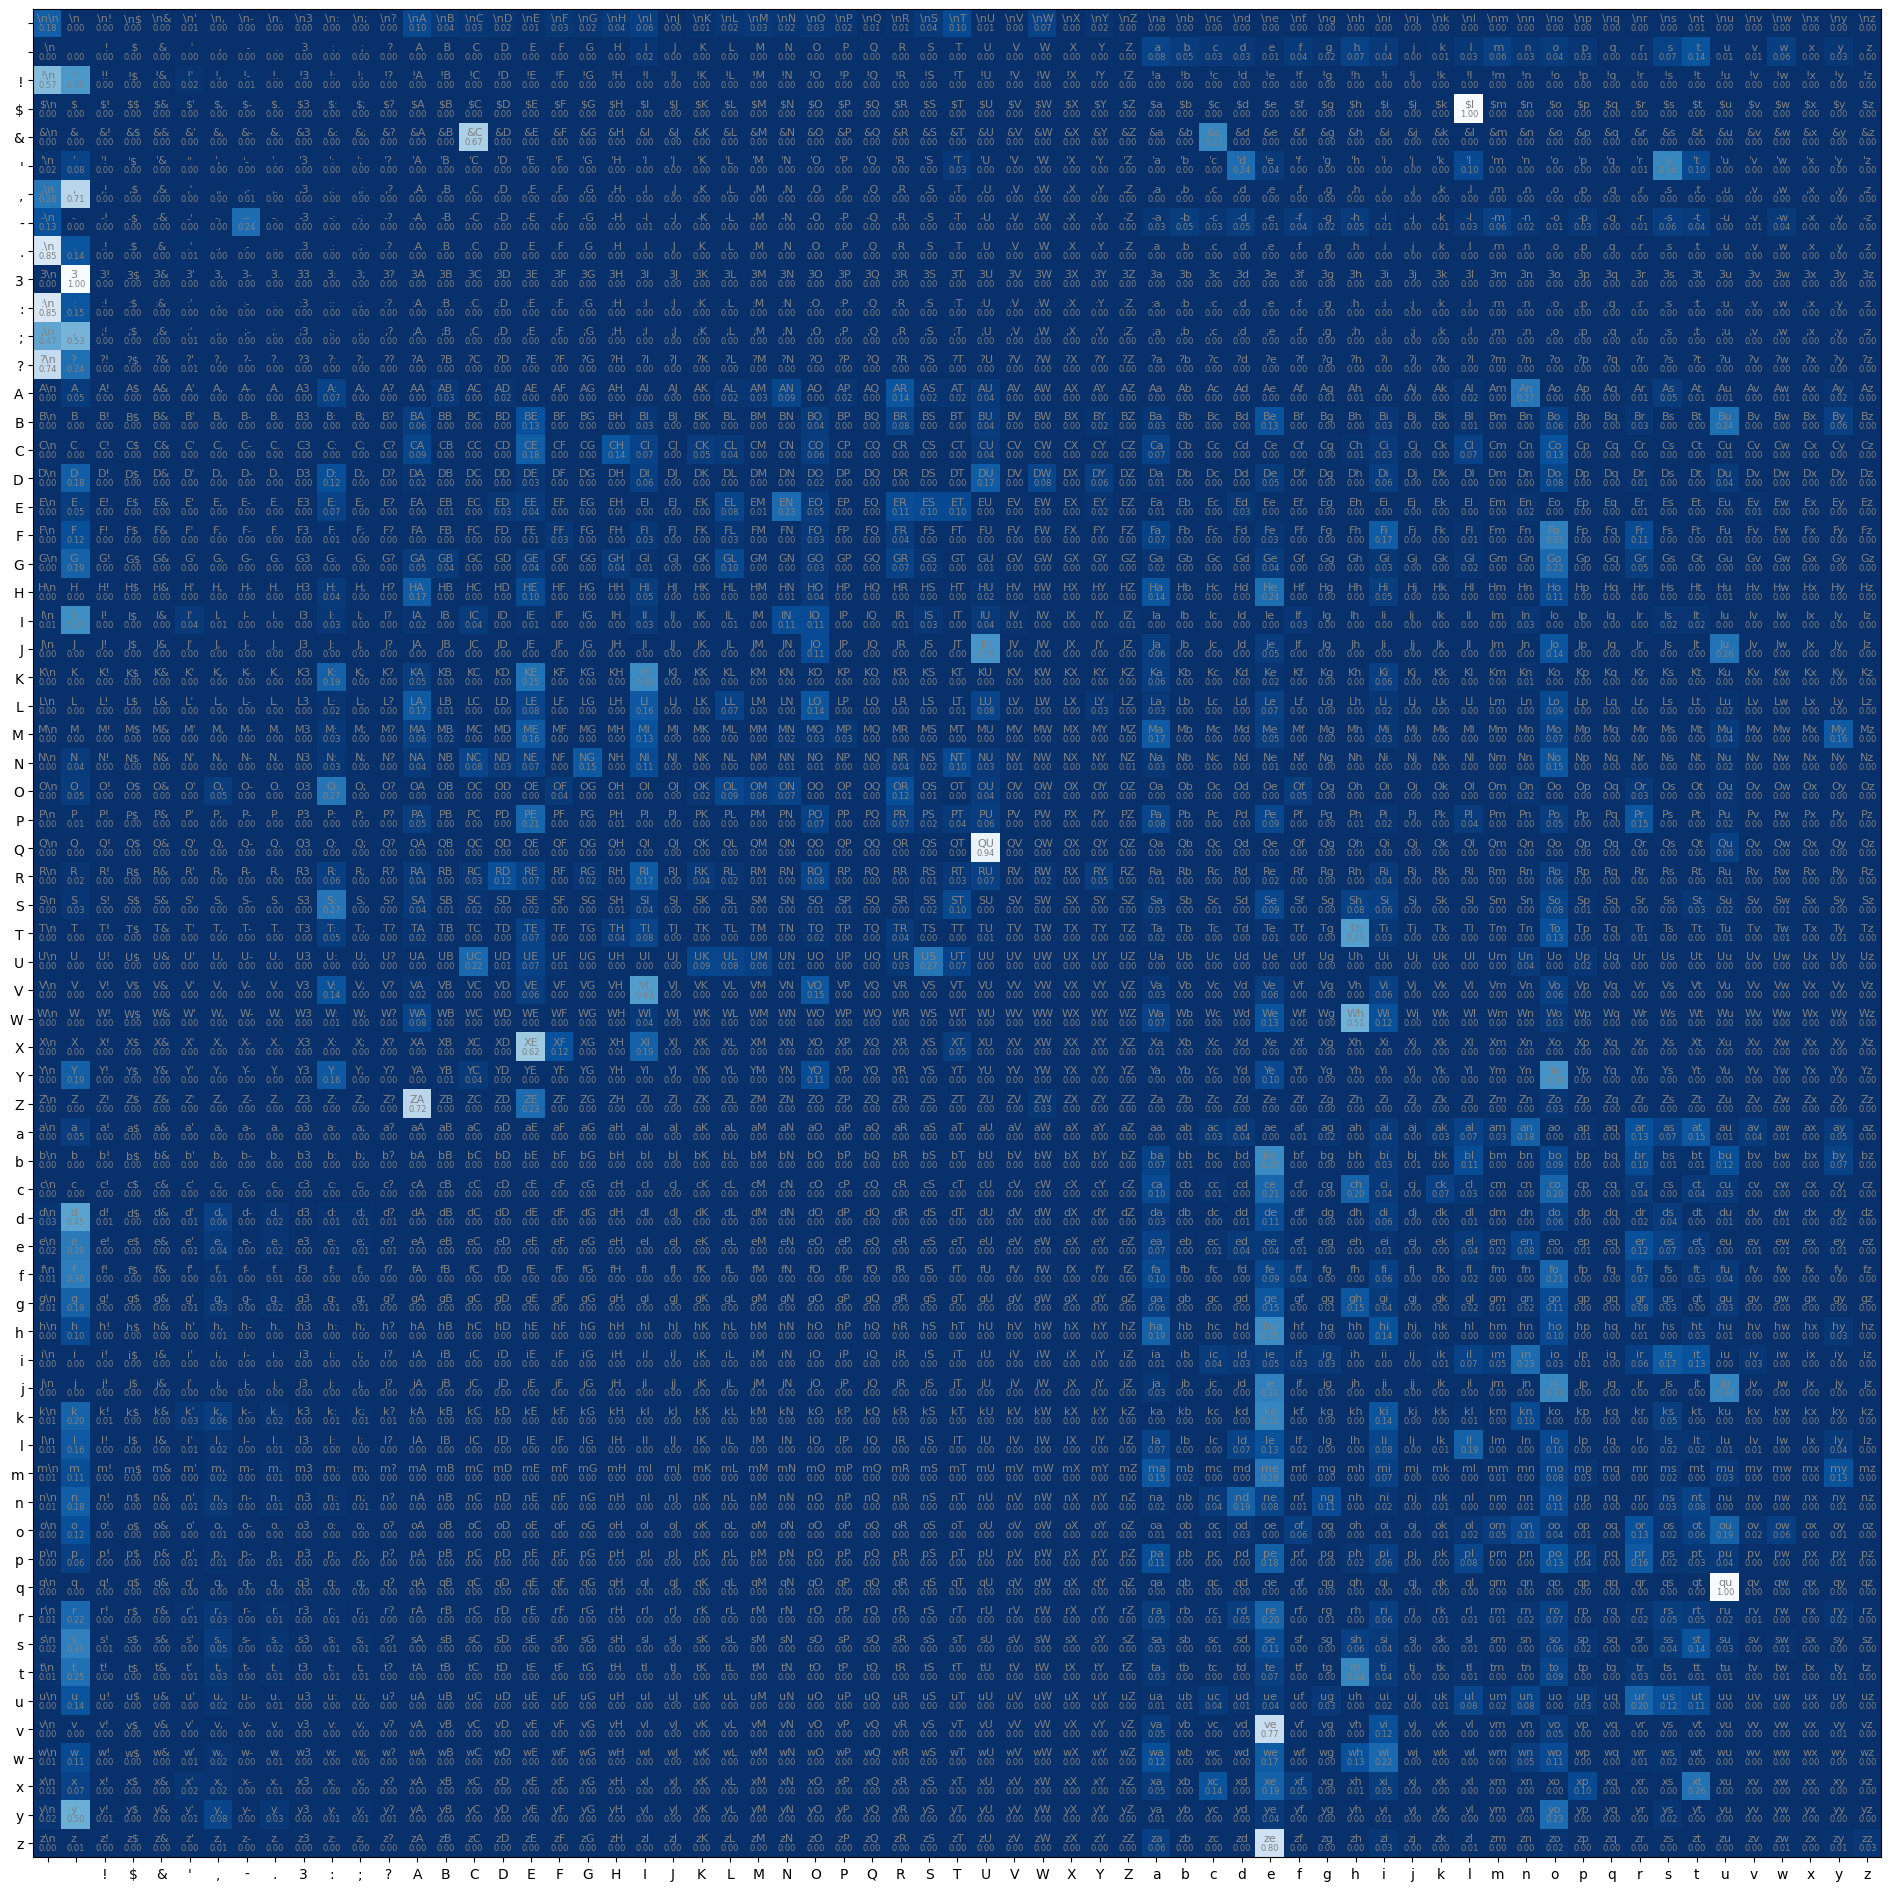

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
im = ax.imshow(bigram, cmap='Blues_r', interpolation='none', vmin=0, vmax=1)


for i in range(vocab_size):
    for j in range(vocab_size):
        seq = f'{repr(itos[i])[1:-1]}{repr(itos[j])[1:-1]}'

        if seq == '$$':
            seq = '\\$\\$' # special case https://github.com/matplotlib/matplotlib/issues/20266/#issuecomment-844462696
        plt.text(j, i, seq, ha='center', va='bottom', color='gray', fontsize=8)
        plt.text(j, i, f'{bigram[i][j].item():.2f}', ha='center', va='top', color='gray', fontsize=6)


ax.set_xticks(range(vocab_size))
ax.set_xticklabels(chars)
ax.set_yticks(range(vocab_size))
ax.set_yticklabels(chars)



# Compare progress through blocks to bigram 


In [ ]:
def blocks(x: torch.Tensor) -> torch.Tensor:
    """Pull apart the blocks sequential module so we can
    mess with the individual items"""


    intermediates = []
    for block in m.blocks:
        sa = block.sa(block.ln1(x))
        x_plus_sa = x + sa 
        ffwd = block.ffwd(block.ln2(x_plus_sa))
        x_plus_ffwd = x_plus_sa + ffwd 

        intermediates.append((x.detach(), sa.detach(), x_plus_sa.detach(), ffwd.detach(), x_plus_ffwd.detach()))
        x = x_plus_ffwd

    return x, intermediates

def probs(x: torch.Tensor) -> torch.Tensor:
    x = m.ln_f(x)
    logits = m.lm_head(x)
    logits = logits[:, -1, :]
    probs = F.softmax(logits, dim=1)
    return probs.detach()


def blocks_progress_probs(idx: torch.Tensor):
    idx = idx[:, -block_size:]

    # Logic from the model's forward() function
    B, T = idx.shape

    assert B == 1 # for this analysis, going to assume just 1 batch

    token_emb = m.token_embedding_table(idx)
    pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
    x = token_emb + pos_emb
    x, intermediates = blocks(x)  # equivalent of x = m.blocks(x)

    prob_items = [
        [probs(item).detach() for item in items]
        for items in intermediates
    ]

    return prob_items


bpp = blocks_progress_probs(str_to_tensor('Citizen'))

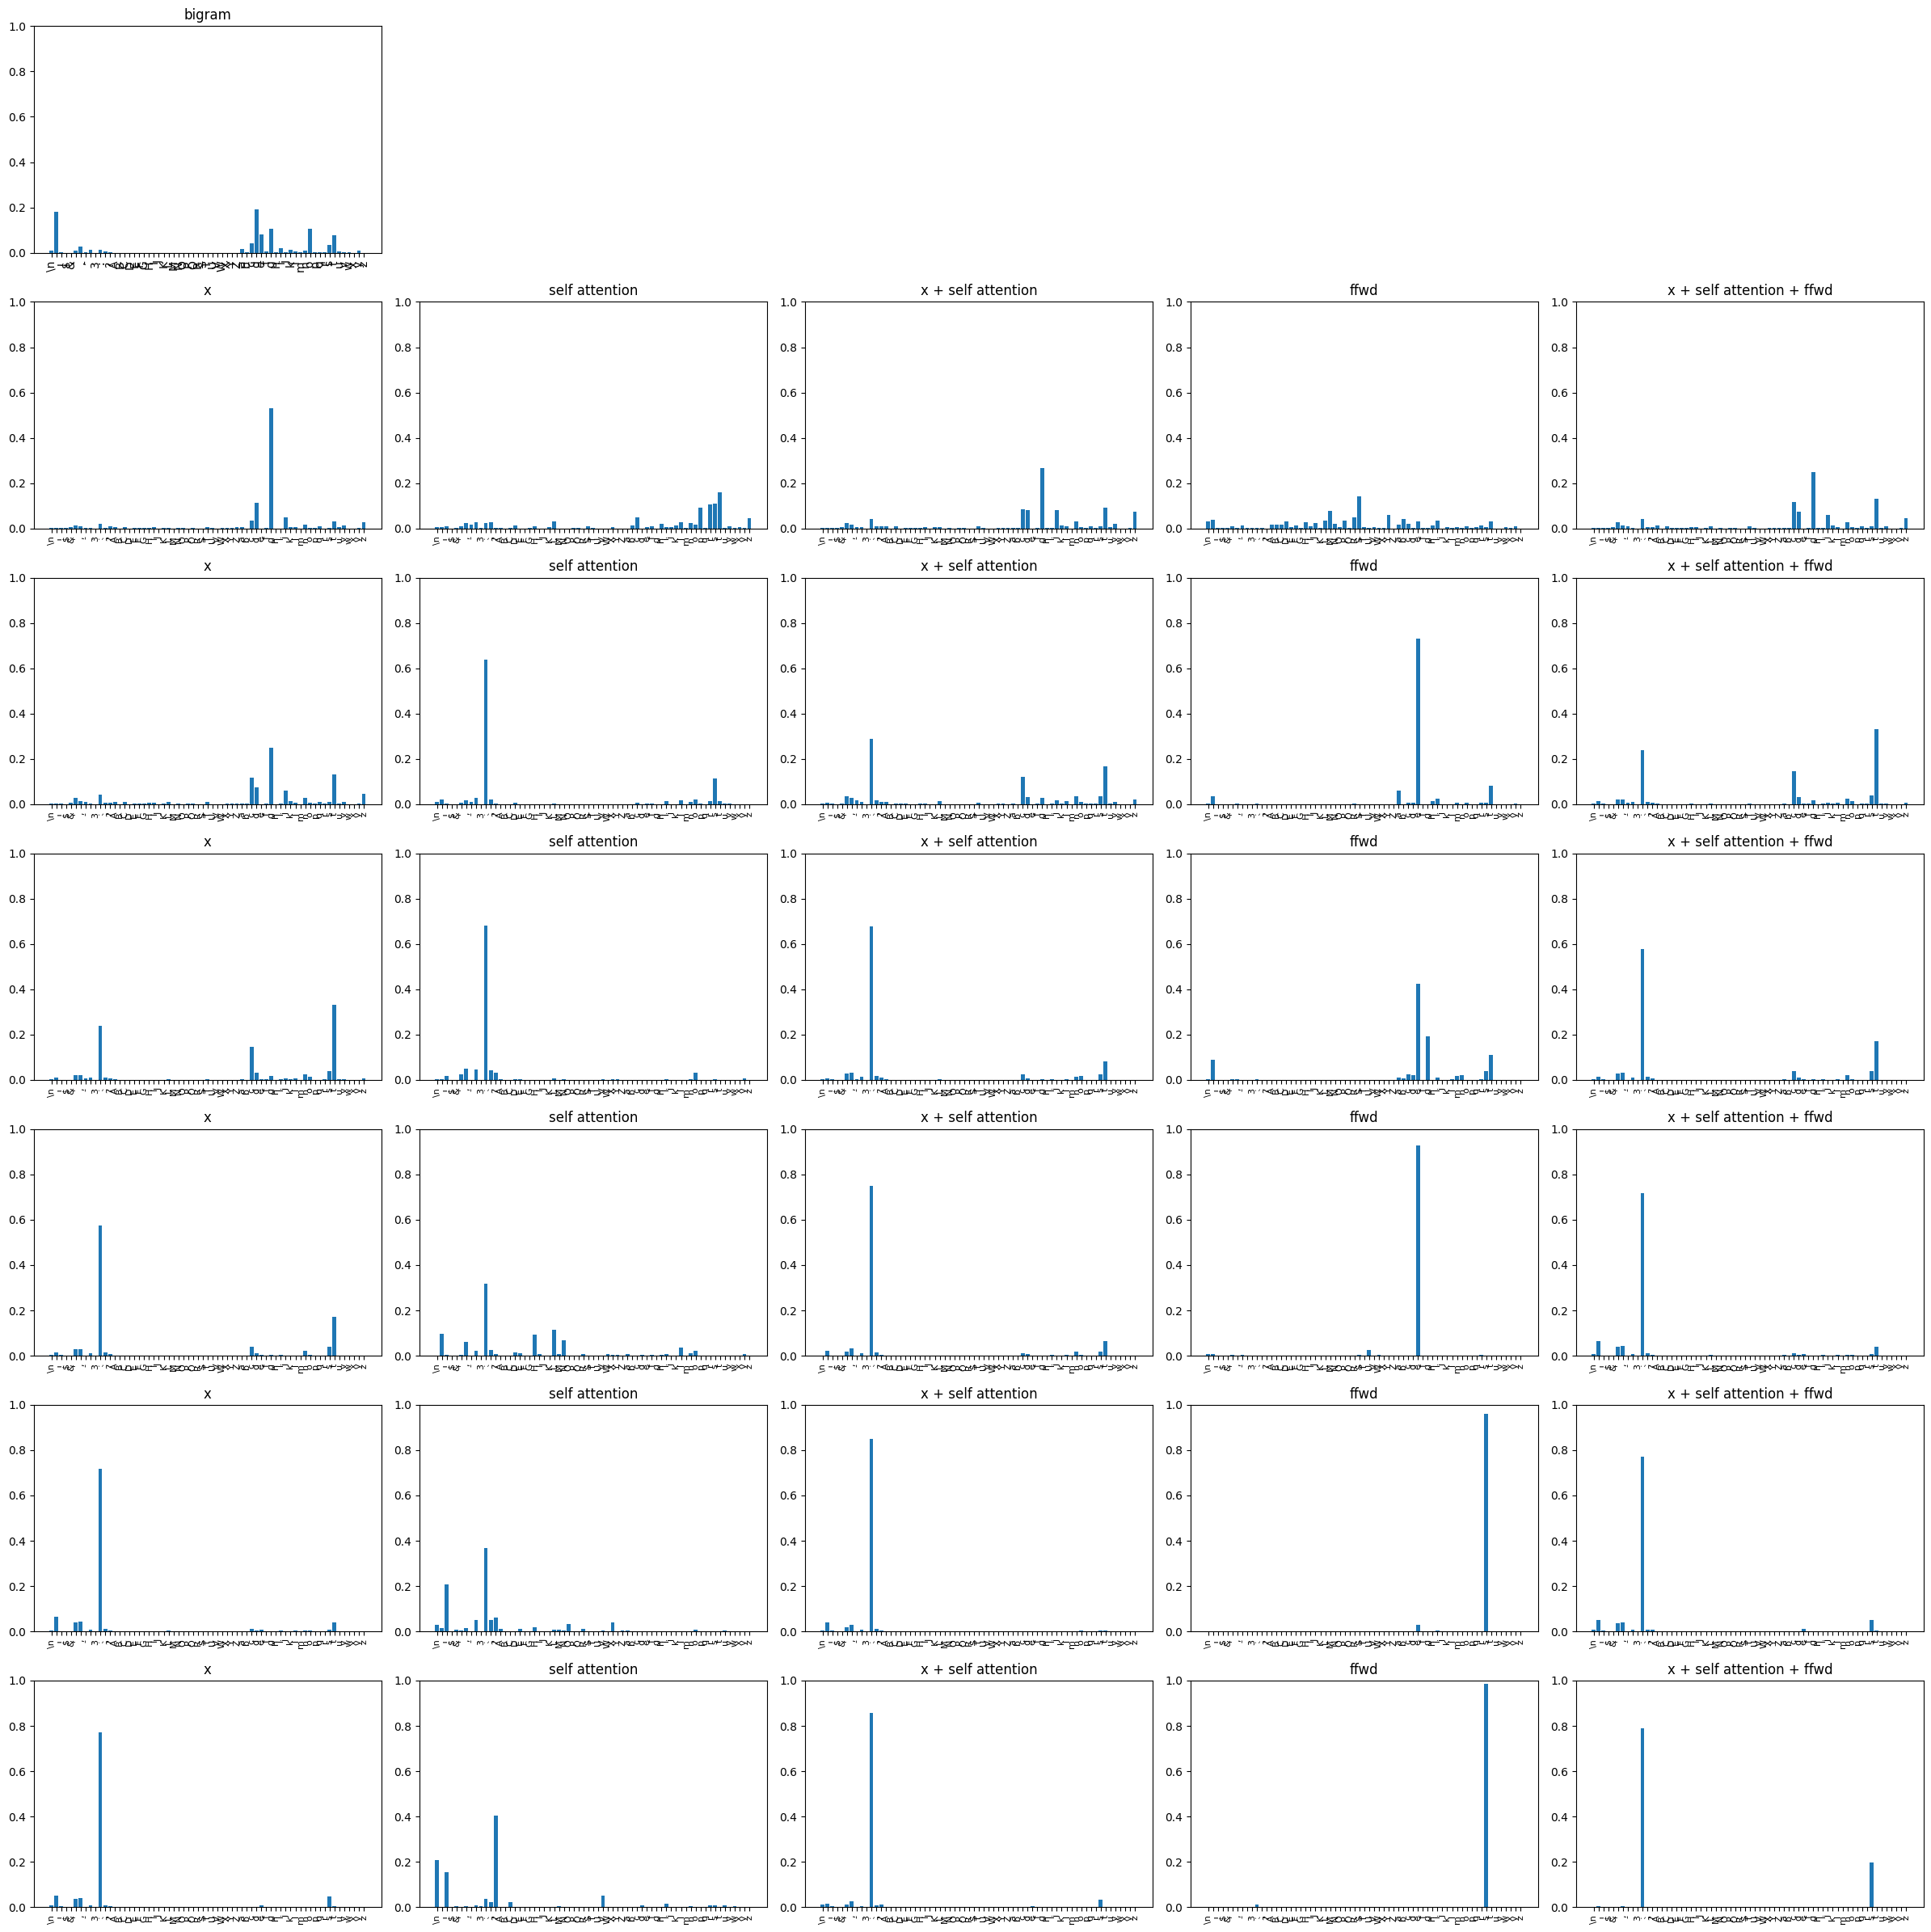

In [ ]:
def plot_bbp(s: str):
    bpp = blocks_progress_probs(str_to_tensor(s))
    nblocks = len(bpp)
    nitems = len(bpp[0])

    fig = plt.figure(figsize=(24, 24))

    nrows = nblocks + 1
    ncols = nitems

    x_indices = np.arange(vocab_size)
    x_labels = [repr(c)[1:-1] for c in chars]

    # Add the bigram row
    ax = fig.add_subplot(nrows, ncols, 1)
    ax.bar(x_indices, bigram[stoi[s[-1]]])
    ax.set_xticks(x_indices, x_labels, rotation='vertical')
    ax.set_title('bigram')
    ax.set_ylim(0., 1.)

    titles = ['x', 'self attention', 'x + self attention', 'ffwd', 'x + self attention + ffwd']
    for b in range(1, nrows):
        for i in range(nitems):
            ax = fig.add_subplot(nrows, ncols, (b*ncols)+i+1)
            ax.bar(x_indices, bpp[b-1][i][0].numpy())
            ax.set_xticks(x_indices, x_labels, rotation='vertical', fontsize=8)
            ax.set_title(titles[i])
            ax.set_ylim(0., 1.)

    plt.tight_layout()


plot_bbp('Citizen')

        

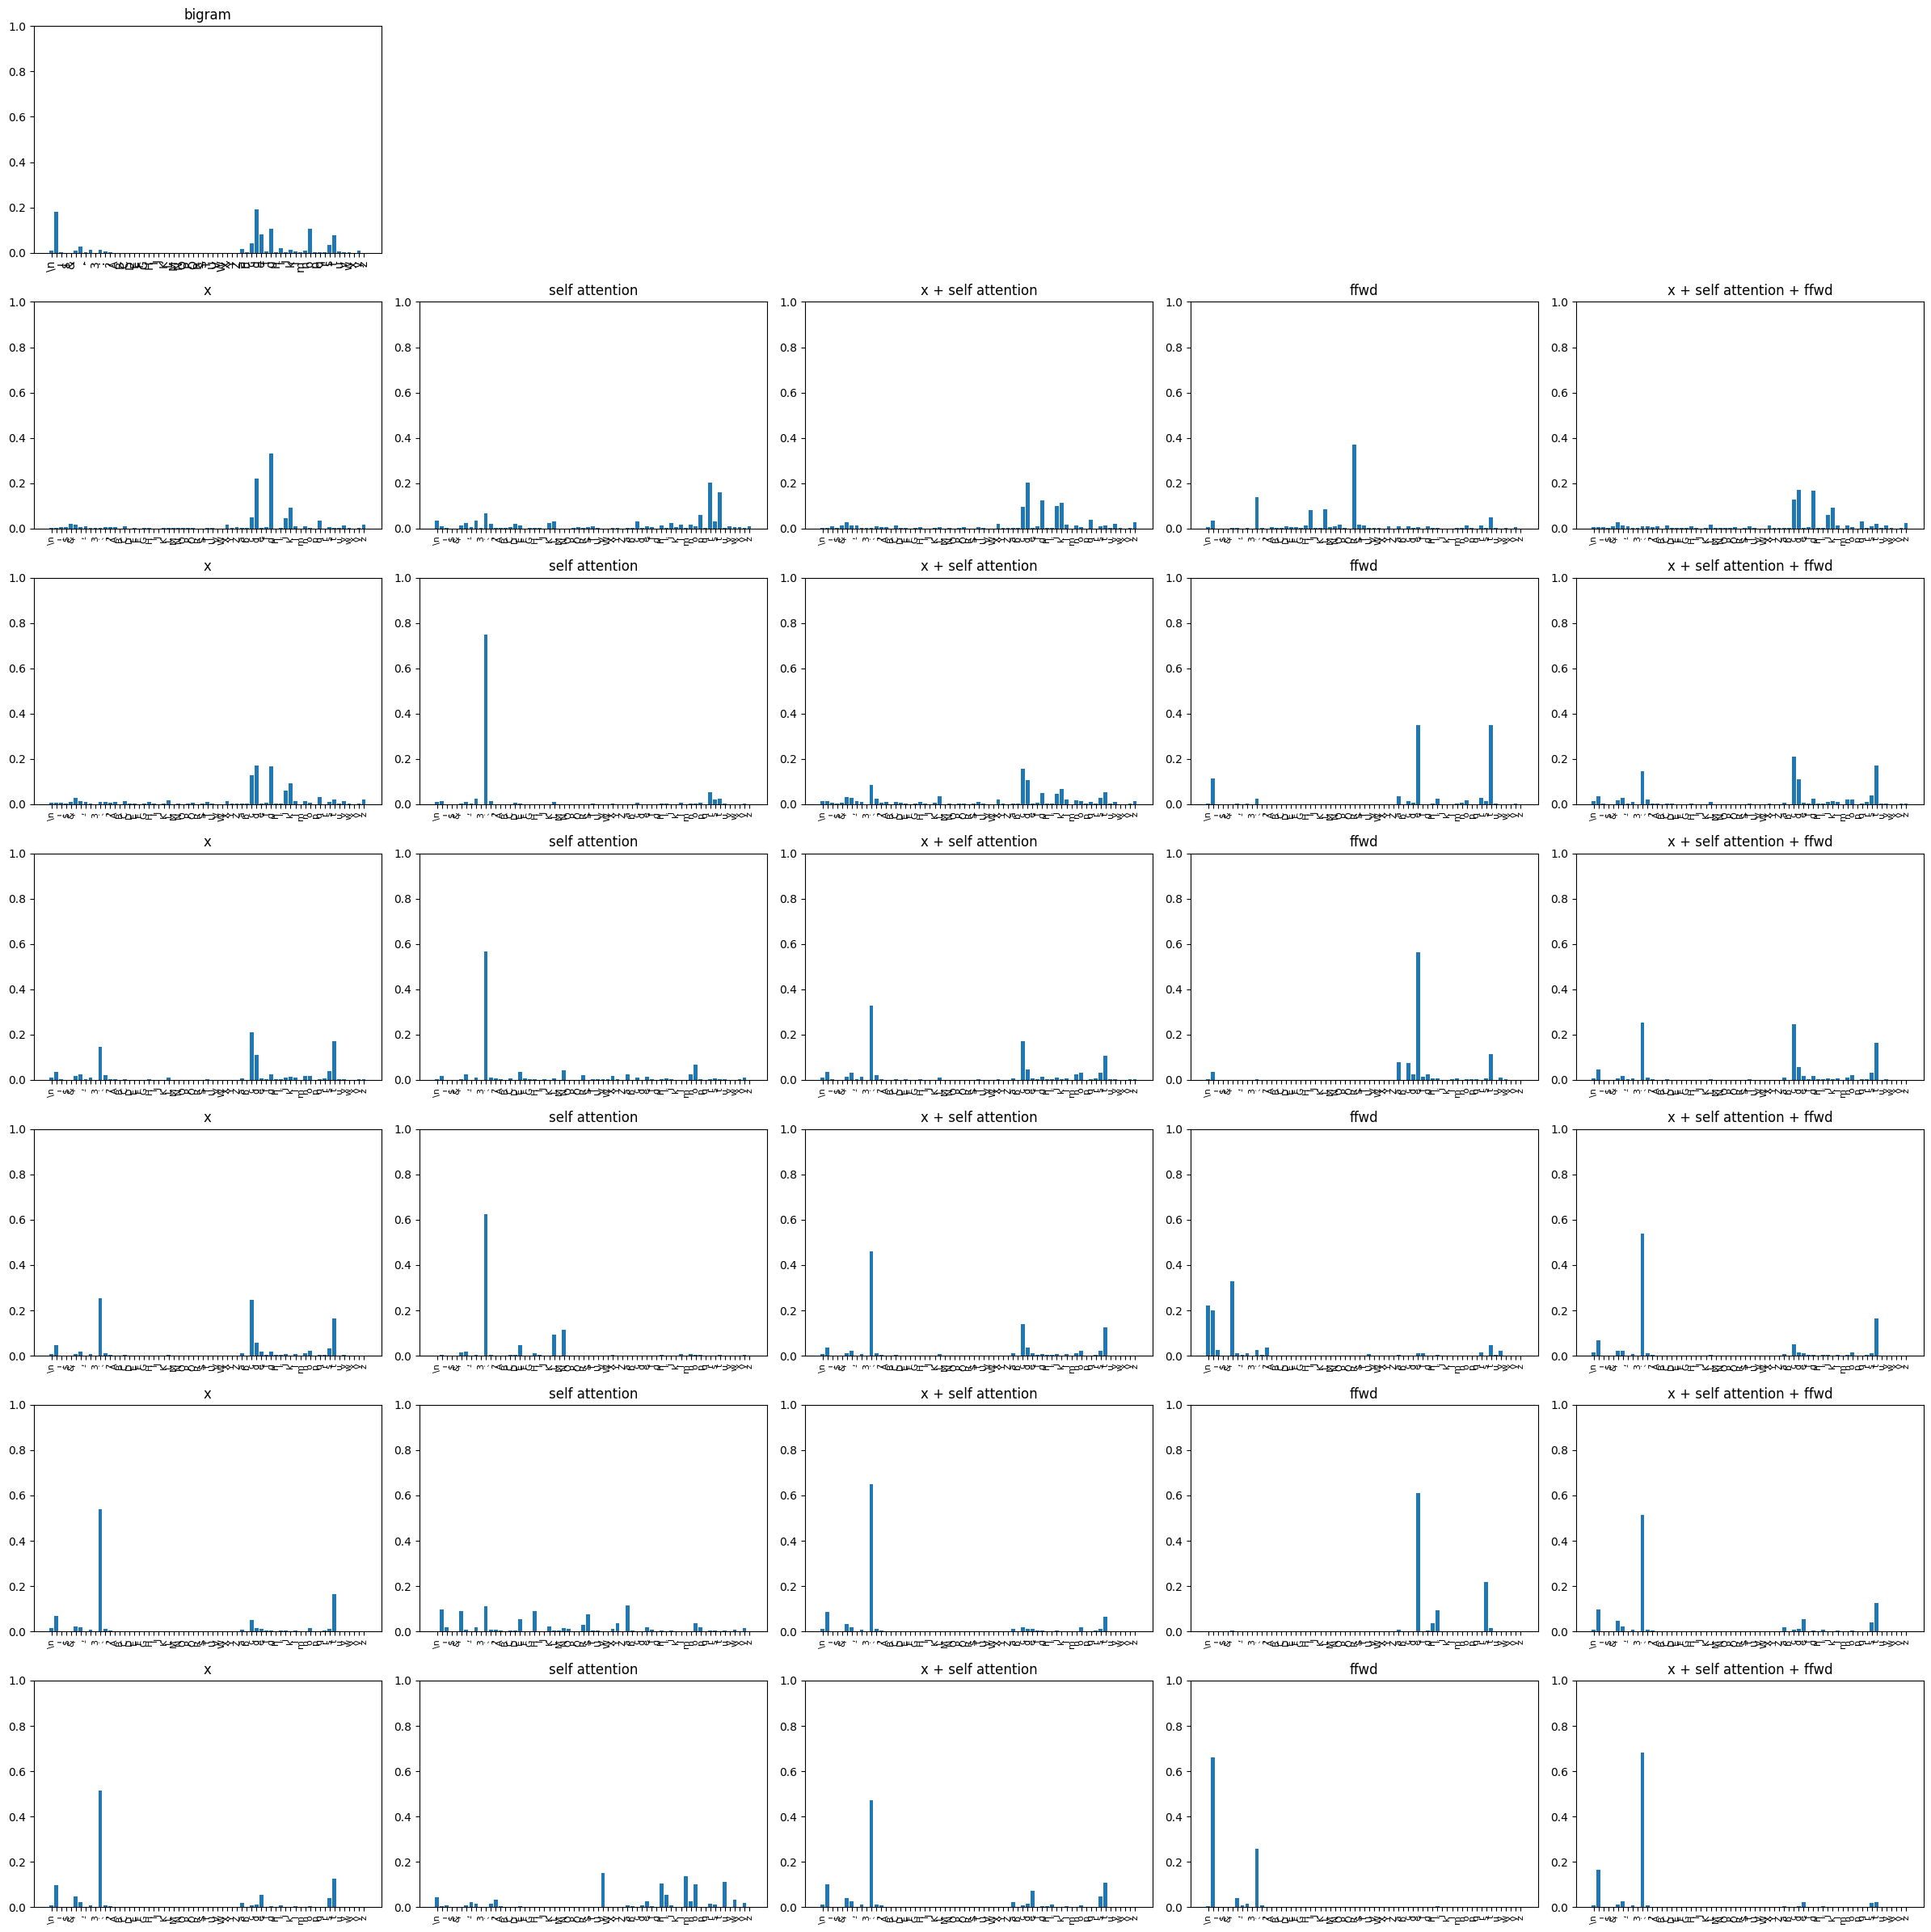

In [ ]:
plot_bbp('zen')

In [ ]:
# see what the heads are doing
def head_output(x: torch.Tensor, block_idx: int, head_idx: int):
    block = m.blocks[block_idx]
    head = block.sa.heads[head_idx]
    return head(block.ln1(x))

def no_op_head_output(x: torch.Tensor, block_idx: int, head_idx: int):
    block = m.blocks[block_idx]
    x_n = block.ln1(x) # do the layer norm on the input
    head_size = n_embed // n_head
    return x_n[:, :, head_idx*head_size:head_idx*head_size + head_size]

def sa_output(block_idx: int, head_outputs: Iterable[torch.Tensor]):
    assert len(head_outputs) == n_head

    sa = m.blocks[block_idx].sa

    out = torch.cat(head_outputs, dim=-1)
    out = sa.proj(out)
    return out  

In [ ]:
s = 'Citizen'
idx = str_to_tensor(s)
idx = idx[:, -block_size:]

# Logic from the model's forward() function
B, T = idx.shape
token_emb = m.token_embedding_table(idx)
pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
x = token_emb + pos_emb


In [ ]:
out1 = sa_output(block_idx=1, head_outputs=[
    head_output(x, block_idx=1, head_idx=0),
    head_output(x, block_idx=1, head_idx=1),
    head_output(x, block_idx=1, head_idx=2),
    head_output(x, block_idx=1, head_idx=3),
    head_output(x, block_idx=1, head_idx=4),
    head_output(x, block_idx=1, head_idx=5),
])

block = m.blocks[1]
out2 = head = block.sa(block.ln1(x))

torch.all(out2 == out1)

tensor(True)

In [ ]:
def plot_probs(p: torch.Tensor, title: str=''):
    fig = plt.figure(figsize=(12, 4))

    x_indices = np.arange(vocab_size)
    x_labels = [repr(c)[1:-1] for c in chars]

    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x_indices, p)
    ax.set_xticks(x_indices, x_labels, rotation='vertical')
    ax.set_title(title)
    ax.set_ylim(0., 1.)
    


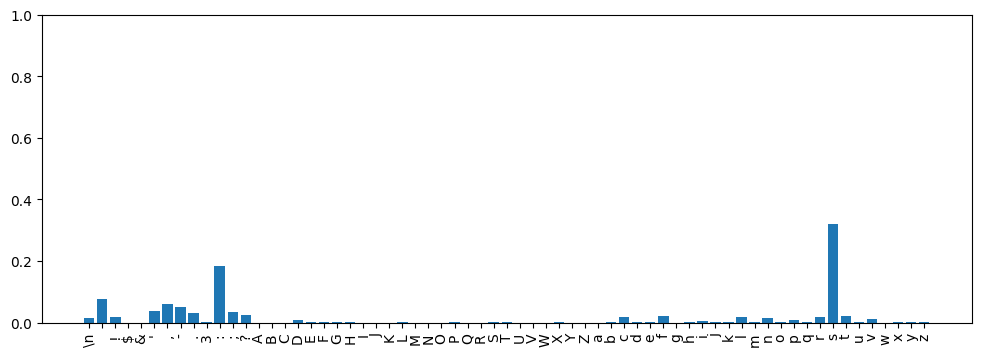

In [ ]:
plot_probs(probs(out1)[0])

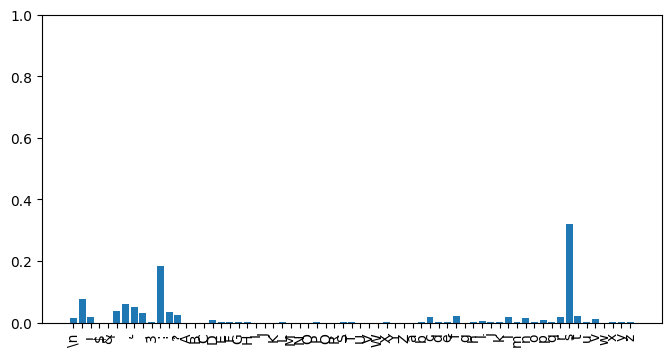

In [ ]:
plot_probs(probs(out2)[0])

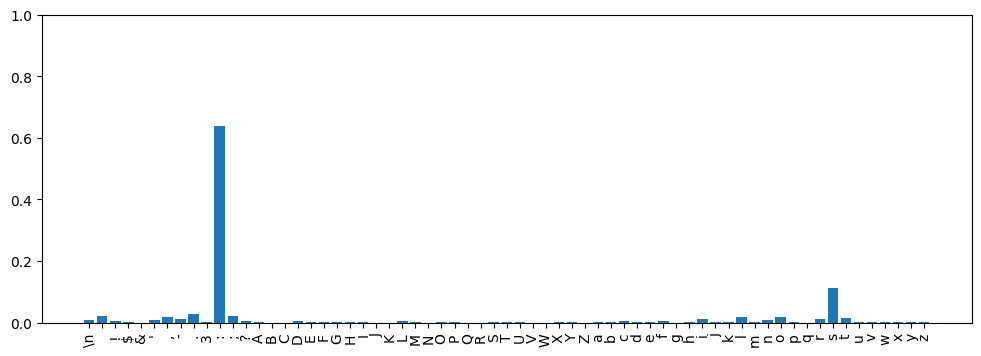

In [ ]:
s = 'Citizen'
idx = str_to_tensor(s)
idx = idx[:, -block_size:]

# Logic from the model's forward() function
B, T = idx.shape
token_emb = m.token_embedding_table(idx)
pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
x = token_emb + pos_emb
x, intermediates = blocks(x)

x_1 = intermediates[1][0]
out = sa_output(block_idx=1, head_outputs=[
    head_output(x_1, block_idx=1, head_idx=0),
    head_output(x_1, block_idx=1, head_idx=1),
    head_output(x_1, block_idx=1, head_idx=2),
    head_output(x_1, block_idx=1, head_idx=3),
    head_output(x_1, block_idx=1, head_idx=4),
    head_output(x_1, block_idx=1, head_idx=5),
])

plot_probs(probs(out)[0])

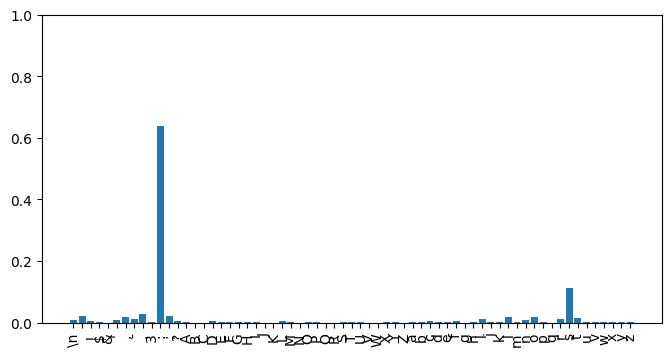

In [ ]:
bpp = blocks_progress_probs(str_to_tensor('Citizen'))
plot_probs(bpp[1][1][0])

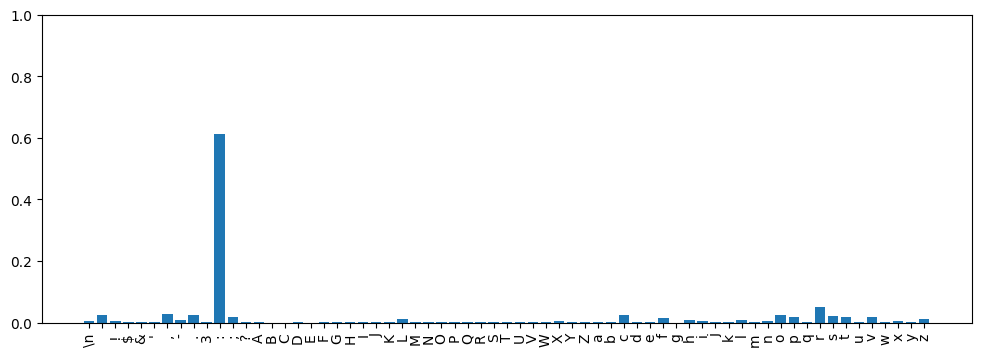

In [ ]:
# OK, the above replicated the output of layer 1, SA, so now mess with the heads

h0 = False
h1 = False
h2 = False
h3 = False
h4 = False
h5 = False 

h0 = True
h1 = True
h2 = True
h3 = True
#h4 = True
#h5 = True 

out = sa_output(block_idx=1, head_outputs=[
    head_output(x_1, block_idx=1, head_idx=0) if h0 is True else no_op_head_output(x_1, block_idx=1, head_idx=0),
    head_output(x_1, block_idx=1, head_idx=1) if h1 is True else no_op_head_output(x_1, block_idx=1, head_idx=1),
    head_output(x_1, block_idx=1, head_idx=2) if h2 is True else no_op_head_output(x_1, block_idx=1, head_idx=2),
    head_output(x_1, block_idx=1, head_idx=3) if h3 is True else no_op_head_output(x_1, block_idx=1, head_idx=3),
    head_output(x_1, block_idx=1, head_idx=4) if h4 is True else no_op_head_output(x_1, block_idx=1, head_idx=4),
    head_output(x_1, block_idx=1, head_idx=5) if h5 is True else no_op_head_output(x_1, block_idx=1, head_idx=5),

])

plot_probs(probs(out)[0])

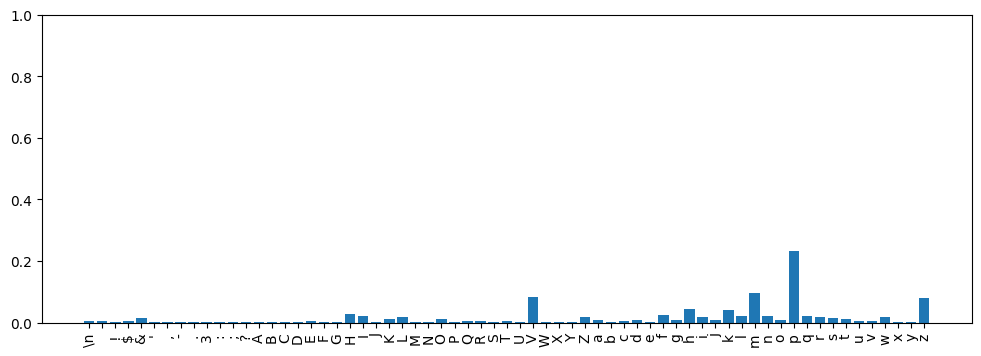

In [ ]:
x_1_n = m.blocks[1].ln1(x_1)
x_1_p = m.blocks[1].sa.proj(x_1_n)
plot_probs(probs(x_1_p)[0])

In [ ]:
def plot_head_variation(h0=False, h1=False, h2=False, h3=False, h4=False, h5=False, title=''):
    out = sa_output(block_idx=1, head_outputs=[
        head_output(x_1, block_idx=1, head_idx=0) if h0 is True else no_op_head_output(x_1, block_idx=1, head_idx=0),
        head_output(x_1, block_idx=1, head_idx=1) if h1 is True else no_op_head_output(x_1, block_idx=1, head_idx=1),
        head_output(x_1, block_idx=1, head_idx=2) if h2 is True else no_op_head_output(x_1, block_idx=1, head_idx=2),
        head_output(x_1, block_idx=1, head_idx=3) if h3 is True else no_op_head_output(x_1, block_idx=1, head_idx=3),
        head_output(x_1, block_idx=1, head_idx=4) if h4 is True else no_op_head_output(x_1, block_idx=1, head_idx=4),
        head_output(x_1, block_idx=1, head_idx=5) if h5 is True else no_op_head_output(x_1, block_idx=1, head_idx=5),
    ])

    plot_probs(probs(out)[0], title=title)
    return out 

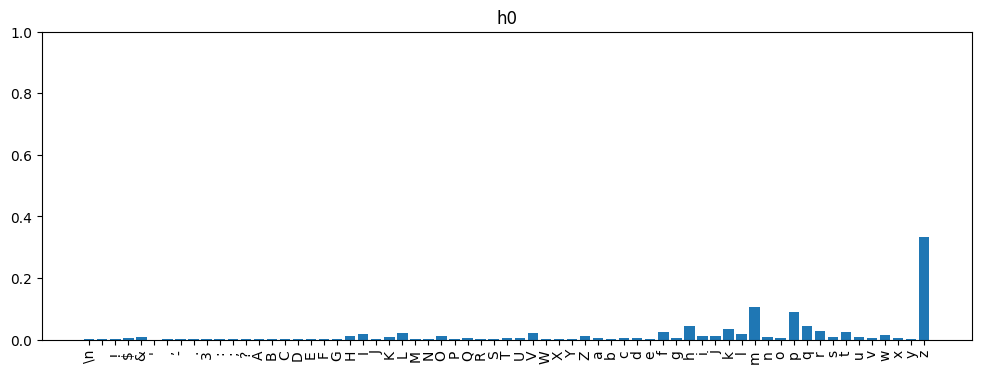

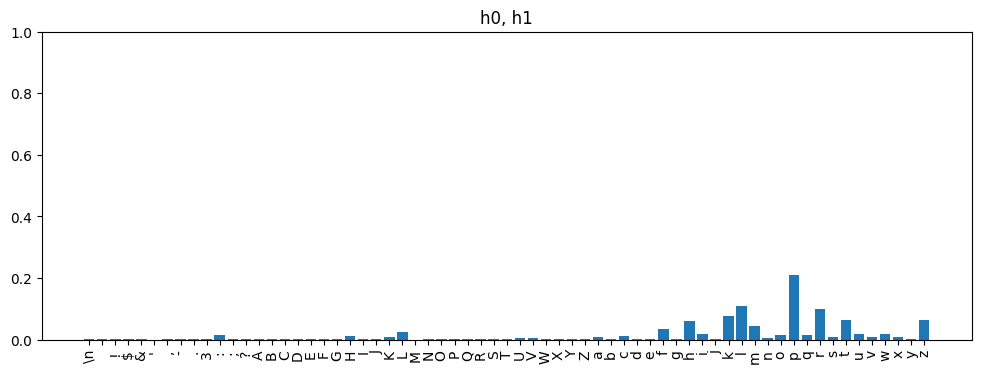

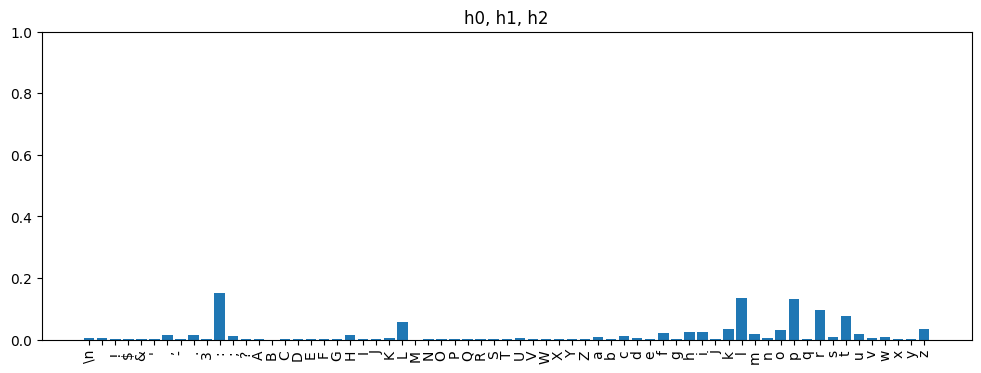

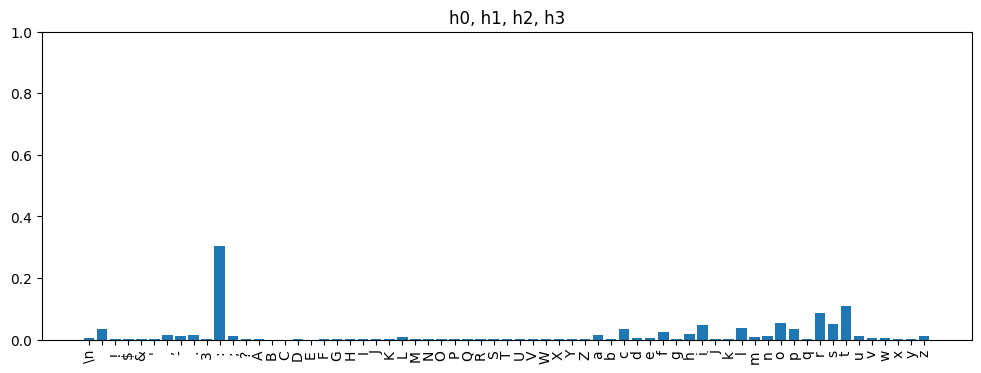

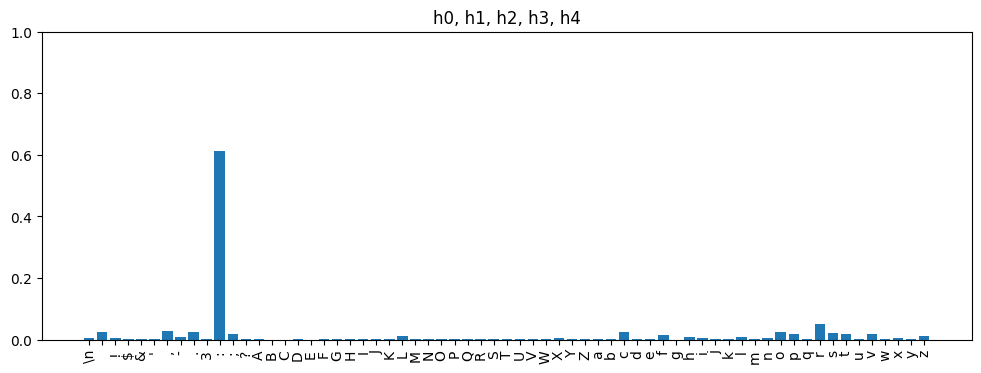

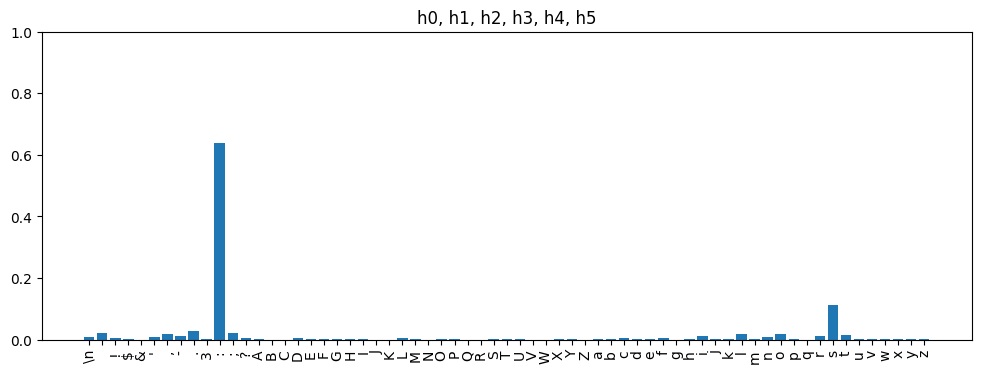

In [ ]:
h0_out = plot_head_variation(h0=True, h1=False, h2=False, h3=False, h4=False, h5=False, title="h0")
h0h1_out = plot_head_variation(h0=True, h1=True, h2=False, h3=False, h4=False, h5=False, title="h0, h1")
h0h1h2_out = plot_head_variation(h0=True, h1=True, h2=True, h3=False, h4=False, h5=False, title="h0, h1, h2")
h0h1h2h3_out = plot_head_variation(h0=True, h1=True, h2=True, h3=True, h4=False, h5=False, title="h0, h1, h2, h3")
h0h1h2h3h4_out = plot_head_variation(h0=True, h1=True, h2=True, h3=True, h4=True, h5=False, title="h0, h1, h2, h3, h4")
h0h1h2h3h4h5_out = plot_head_variation(h0=True, h1=True, h2=True, h3=True, h4=True, h5=True, title="h0, h1, h2, h3, h4, h5")


In [ ]:
h0_out.shape

torch.Size([1, 7, 384])

In [ ]:
char_to_embedding[':'].shape

torch.Size([384])

In [ ]:
def compare_cosine_sims(to_char: str):
    cos = nn.CosineSimilarity(dim=-1)

    print(f"cos(h0_out, {to_char}) = {cos(h0_out[:, -1, :], char_to_embedding[to_char]).item():.2f}")
    print(f"cos(h0h1_out, {to_char}) = {cos(h0h1_out[:, -1, :], char_to_embedding[to_char]).item():.2f}")
    print(f"cos(h0h1h2_out, {to_char}) = {cos(h0h1h2_out[:, -1, :], char_to_embedding[to_char]).item():.2f}")
    print(f"cos(h0h1h2h3_out, {to_char}) = {cos(h0h1h2h3_out[:, -1, :], char_to_embedding[to_char]).item():.2f}")
    print(f"cos(h0h1h2h3h4_out, {to_char}) = {cos(h0h1h2h3h4_out[:, -1, :], char_to_embedding[to_char]).item():.2f}")
    print(f"cos(h0h1h2h3h4h5_out, {to_char}) = {cos(h0h1h2h3h4h5_out[:, -1, :], char_to_embedding[to_char]).item():.2f}")



In [ ]:
compare_cosine_sims(':')

cos(h0_out, :) = -0.04
cos(h0h1_out, :) = 0.04
cos(h0h1h2_out, :) = 0.07
cos(h0h1h2h3_out, :) = 0.12
cos(h0h1h2h3h4_out, :) = 0.11
cos(h0h1h2h3h4h5_out, :) = 0.11


In [ ]:
compare_cosine_sims('s')

cos(h0_out, s) = 0.09
cos(h0h1_out, s) = 0.07
cos(h0h1h2_out, s) = 0.04
cos(h0h1h2h3_out, s) = 0.05
cos(h0h1h2h3h4_out, s) = 0.00
cos(h0h1h2h3h4h5_out, s) = 0.05


In [ ]:
compare_cosine_sims('z')

cos(h0_out, z) = 0.10
cos(h0h1_out, z) = 0.08
cos(h0h1h2_out, z) = 0.05
cos(h0h1h2h3_out, z) = 0.07
cos(h0h1h2h3h4_out, z) = 0.07
cos(h0h1h2h3h4h5_out, z) = 0.08


In [ ]:
cos = nn.CosineSimilarity(dim=-1)

print(f"cos(h0_out, :) = {cos(h0_out[:, -1, :], char_to_embedding[':']).item():.2f}")
print(f"cos(h0h1_out, :) = {cos(h0h1_out[:, -1, :], char_to_embedding[':']).item():.2f}")
print(f"cos(h0h1h2_out, :) = {cos(h0h1h2_out[:, -1, :], char_to_embedding[':']).item():.2f}")
print(f"cos(h0h1h2h3_out, :) = {cos(h0h1h2h3_out[:, -1, :], char_to_embedding[':']).item():.2f}")


cos(h0_out, :) = -0.04
cos(h0h1_out, :) = 0.04
cos(h0h1h2_out, :) = 0.07
cos(h0h1h2h3_out, :) = 0.12


In [ ]:
h0_out[:, -1, :].shape
#char_to_embedding[':'].shape
#torch.cdist(h0_out[:, -1, :], char_to_embedding[':'].unsqueeze(dim=0), p=2)

def euc_dist(x: torch.Tensor, char: str): 
    return torch.cdist(x, char_to_embedding[char].unsqueeze(dim=0), p=2).item()


def compare_euc_dists(to_char: str):
    print(f"euc_dist(h0_out, {to_char}) = {euc_dist(h0_out[:, -1, :], to_char):.2f}")
    print(f"euc_dist(h0h1_out, {to_char}) = {euc_dist(h0h1_out[:, -1, :], to_char):.2f}")
    print(f"euc_dist(h0h1h2_out, {to_char}) = {euc_dist(h0h1h2_out[:, -1, :], to_char):.2f}")
    print(f"euc_dist(h0h1h2h3_out, {to_char}) = {euc_dist(h0h1h2h3_out[:, -1, :], to_char):.2f}")
    print(f"euc_dist(h0h1h2h3h4_out, {to_char}) = {euc_dist(h0h1h2h3h4_out[:, -1, :], to_char):.2f}")
    print(f"euc_dist(h0h1h2h3h4h5_out, {to_char}) = {euc_dist(h0h1h2h3h4h5_out[:, -1, :], to_char):.2f}")



In [ ]:
compare_euc_dists(':')

euc_dist(h0_out, :) = 33.14
euc_dist(h0h1_out, :) = 31.88
euc_dist(h0h1h2_out, :) = 31.43
euc_dist(h0h1h2h3_out, :) = 30.64
euc_dist(h0h1h2h3h4_out, :) = 30.68
euc_dist(h0h1h2h3h4h5_out, :) = 30.70


In [ ]:
compare_euc_dists('s')

euc_dist(h0_out, s) = 29.02
euc_dist(h0h1_out, s) = 28.96
euc_dist(h0h1h2_out, s) = 29.30
euc_dist(h0h1h2h3_out, s) = 28.83
euc_dist(h0h1h2h3h4_out, s) = 29.27
euc_dist(h0h1h2h3h4h5_out, s) = 28.77


In [ ]:
compare_euc_dists('z')

euc_dist(h0_out, z) = 27.05
euc_dist(h0h1_out, z) = 27.02
euc_dist(h0h1h2_out, z) = 27.23
euc_dist(h0h1h2h3_out, z) = 26.76
euc_dist(h0h1h2h3h4_out, z) = 26.66
euc_dist(h0h1h2h3h4h5_out, z) = 26.56


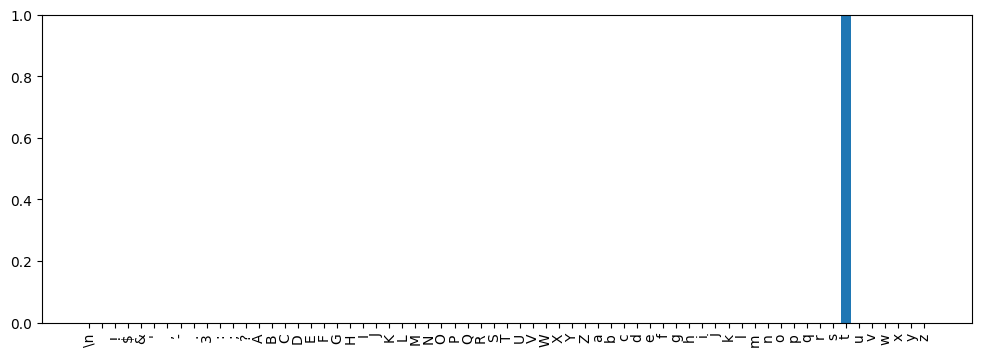

In [ ]:
plot_probs(probs((char_to_embedding['t']).unsqueeze(dim=0).unsqueeze(dim=0))[0])

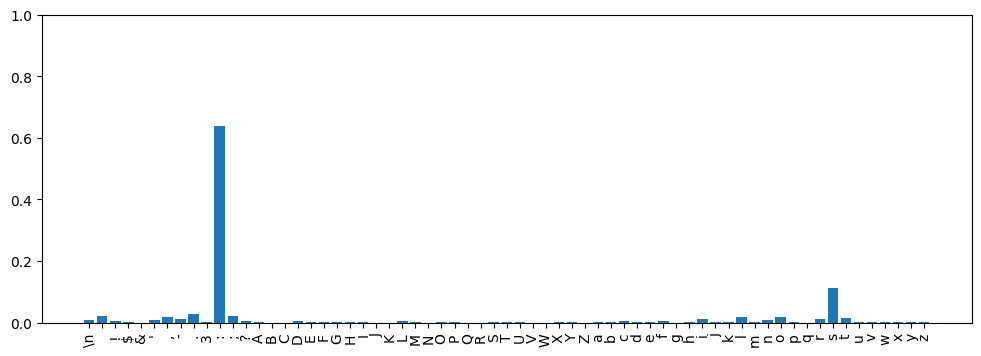

In [ ]:
plot_probs(probs(h0h1h2h3h4h5_out)[0])

Observations: 
* h0 alone gives a tiny prediction for :, small prediction for s, big prediction for z
* adding h1 bumps the prediction for :, doesn't do much with s, and tamps down z
* adding h2 bumps : quite a bit, doesn't do much with s, further tamps down z
* adding h3 bumps : by roughly what h2 did again, gives a slight bump to s, and brings down z a little more

# Visualize attention heads


In [ ]:
def encode_input(s: str) -> torch.Tensor:
    idx = str_to_tensor(s)
    idx = idx[:, -block_size:]

    # Logic from the model's forward() function
    B, T = idx.shape

    assert B == 1 # for analysis, going to assume just 1 batch

    token_emb = m.token_embedding_table(idx)
    pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
    x = token_emb + pos_emb

    return x


def attn_details(s: str, block_idx: int, head_idx: int) -> torch.Tensor:
    x = encode_input(s)

    for i, block in enumerate(m.blocks):
        if i == block_idx:
            x = block.ln1(x)
            head = block.sa.heads[head_idx]

            # equivalent of head(x):
            B, T, C = x.shape
            k = head.key(x)
            q = head.query(x)

            wei = q @ k.transpose(-2, -1) * C**-0.5
            wei = wei.masked_fill(head.tril[:T, :T] == 0, float('-inf'))
            wei = F.softmax(wei, dim=-1)

            v = head.value(x)
            out = wei @ v             

            return x.detach(), k.detach(), q.detach(), wei.detach(), v.detach(), out.detach()
        x = block(x)


In [ ]:
x, k, q, wei, v, out = attn_details('Citizen', block_idx=1, head_idx=0)

In [ ]:
wei.shape

torch.Size([1, 7, 7])

In [ ]:
def plot_wei(s: str, wei: torch.Tensor):
    B, T, T = wei.shape

    assert B == 1 # for analysis, assume just 1 batch

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(wei[0], cmap="viridis", vmin=0, vmax=1)

    ax.set_xticks(np.arange(T), s)
    ax.set_yticks(np.arange(T), s)

    plt.colorbar(im, ax=[ax], location='top')



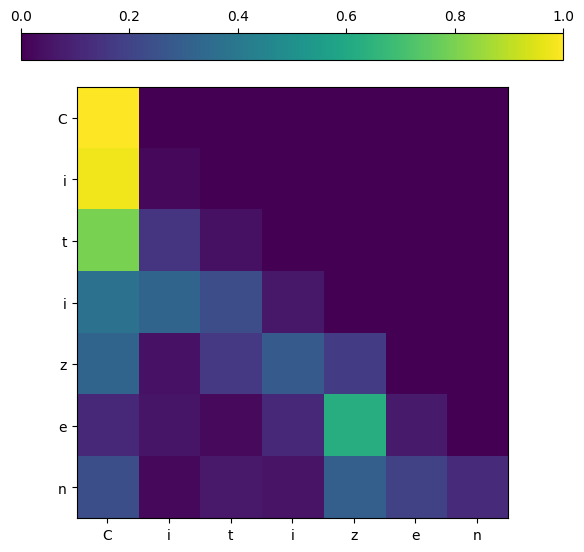

In [ ]:
plot_wei('Citizen', wei)

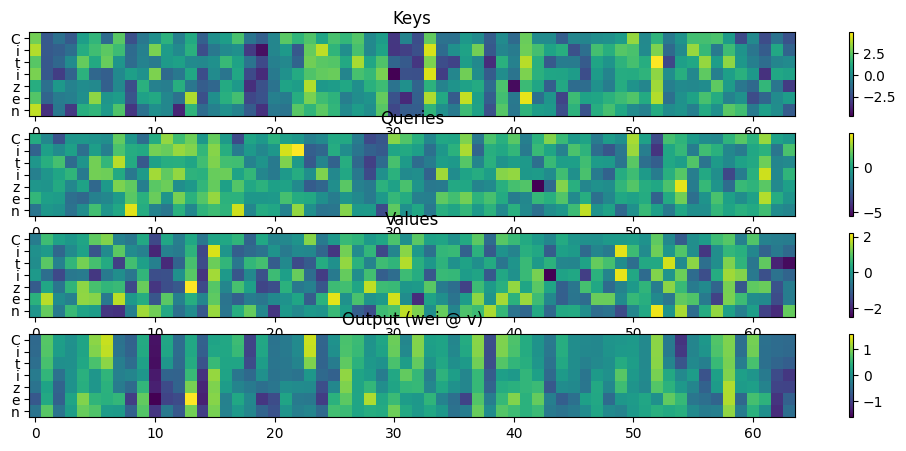

In [ ]:
def plot_kqvout(s: str, k: torch.Tensor, q: torch.Tensor, v: torch.Tensor, out: torch.Tensor):
    titles = ["Keys", "Queries", "Values", "Output (wei @ v)"]
    fig = plt.figure(figsize=(14, 5))
    nrows = 4
    ncols = 1 


    for i, (title, data) in enumerate(zip(titles, [k, q, v, out])): 
        ax = fig.add_subplot(nrows, ncols, i+1)
        im = ax.imshow(data[0], cmap="viridis")
        ax.set_yticks(np.arange(T), s)
        ax.set_title(title)
        plt.colorbar(im, ax=[ax], location='right')


plot_kqvout('Citizen', k, q, v, out)

# Skip blocks analysis

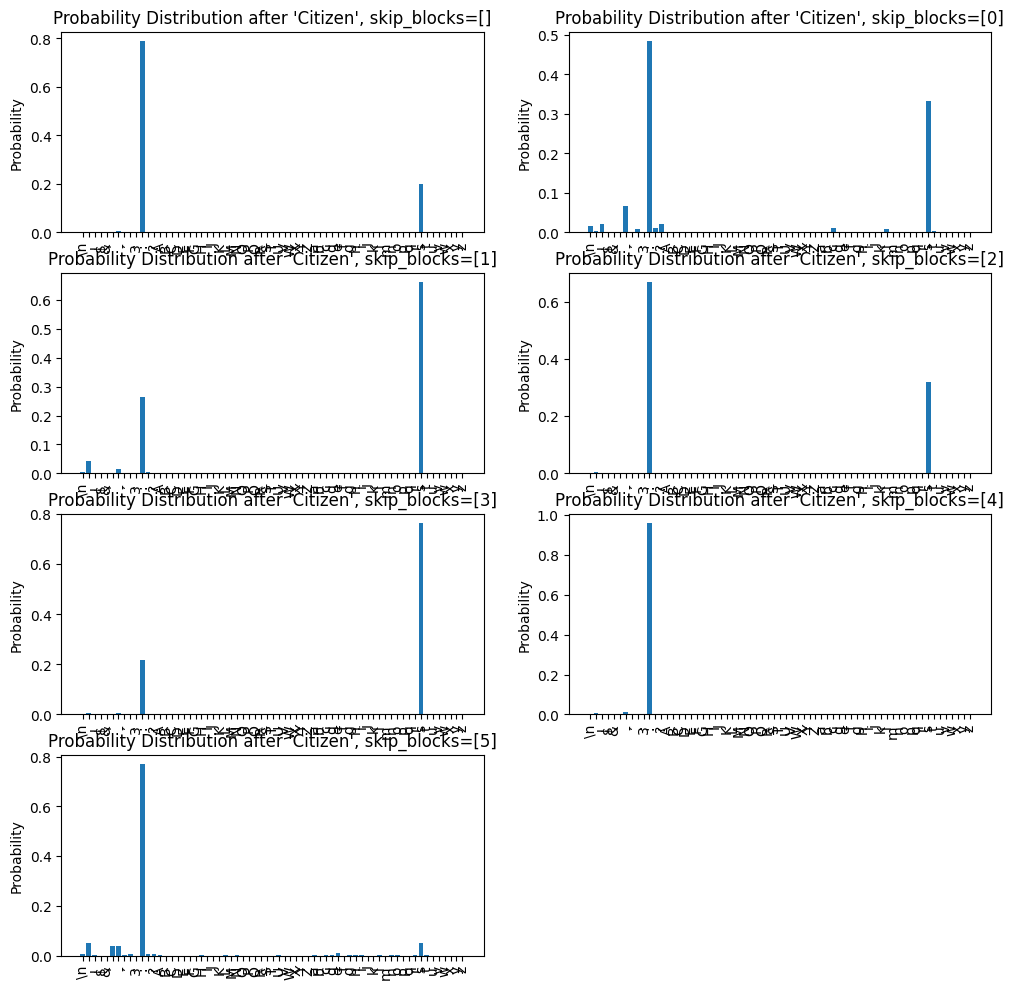

In [ ]:
def blocks(x: torch.Tensor, skip_blocks: Iterable[int] = []) -> torch.Tensor:
    """Pull apart the blocks sequential module so we can
    mess with the individual items"""
    for i, block in enumerate(m.blocks):
        if i in skip_blocks:
            continue
        x = block(x)
    return x


def get_next_probs(
    initial_str: str, skip_blocks: Iterable[int] = [],
):
  idx = str_to_tensor(initial_str)
  idx = idx[:, -block_size:]

  # Logic from the model's forward() function
  B, T = idx.shape
  token_emb = m.token_embedding_table(idx)
  pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
  x = token_emb + pos_emb
  x = blocks(x, skip_blocks=skip_blocks)  # equivalent of x = m.blocks(x)
  x = m.ln_f(x)
  logits = m.lm_head(x)

  # focus only on the last time step
  logits = logits[:, -1, :]  # logits is now (B, 1, C)
  probs = F.softmax(logits, dim=1)
  return probs 


def plot_next_probs(
    probs: np.ndarray, titles: Iterable[str], nrows: int, ncols: int, figsize: Tuple[int, int] = (12, 12)
):
    items, _ = probs.shape

    assert nrows * ncols >= items

    x_indices = np.arange(vocab_size)
    x_labels = [repr(c)[1:-1] for c in chars]

    fig = plt.figure(figsize=figsize)

    for i in range(items):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.bar(x_indices, probs[i])
        ax.set_xticks(x_indices, x_labels, rotation='vertical')
        ax.set_ylabel("Probability")
        ax.set_title(titles[i])

skip_blocks_vals = [[]]
for i in range(n_layer):
    skip_blocks_vals.append([i])

s = 'Citizen'

probs = np.array([
    get_next_probs(s, skip_blocks=skip_blocks).detach().numpy().flatten()
    for skip_blocks in skip_blocks_vals
])

titles = [
    f"Probability Distribution after '{s}', skip_blocks={skip_blocks}"
    for skip_blocks in skip_blocks_vals
]

plot_next_probs(probs, titles, 4, 2)


In [ ]:
print(decode(val_data[11:100].tolist()))

Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, 


In [ ]:
# Attempt to do the logit lens thing

In [ ]:
def get_input_and_correct(data: torch.Tensor=val_data, fragment_size=16, start_idx=0):
    input = data[start_idx:start_idx+fragment_size]
    correct = data[start_idx+1:start_idx+fragment_size+1]

    return input, correct


In [ ]:
#input, correct = get_input_and_correct(val_data, start_idx=11)
input, correct = get_input_and_correct(val_data, start_idx=32)
input, correct, decode(input.tolist()), decode(correct.tolist())

(tensor([56,  1, 14, 39, 54, 58, 47, 57, 58, 39,  8,  0,  0, 14, 13, 28]),
 tensor([ 1, 14, 39, 54, 58, 47, 57, 58, 39,  8,  0,  0, 14, 13, 28, 32]),
 'r Baptista.\n\nBAP',
 ' Baptista.\n\nBAPT')

In [ ]:
def blocks(x: torch.Tensor) -> torch.Tensor:
    """Pull apart the blocks sequential module so we can
    mess with the individual items"""
    intermediates = [x.detach()]
    for block in m.blocks:
        x = block(x)
        intermediates.append(x.detach())
    return x, intermediates

def logit_lens(input: torch.Tensor):
    idx = torch.stack([input])
    idx = idx[:, -block_size:]

    # Logic from the model's forward() function
    B, T = idx.shape

    assert B == 1 # for this analysis, going to assume just 1 batch

    token_emb = m.token_embedding_table(idx)
    pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
    x = token_emb + pos_emb
    x, intermediates = blocks(x)  # equivalent of x = m.blocks(x)

    top1_preds = []
    top1_probs = []
    for x in intermediates:
        x = m.ln_f(x)
        logits = m.lm_head(x)
        top1 = torch.argmax(logits, dim=-1, keepdim=False)
        top1_list = top1[0].tolist()
        top1_chars = decode(top1_list)
        top1_preds.append(top1_chars)
        all_probs = F.softmax(logits, dim=-1)
        probs = [all_probs[0][i][j].item() for i, j in enumerate(top1_list)]
        top1_probs.append(probs)


    return top1_preds, top1_probs

logit_lens(input), decode(correct.tolist())

((['pbdgu?zt,zSDFeSE',
   'gbEyl,zt,r\nDFYUH',
   ' cettint n\n\nFURH',
   ' bettint n\n\nFERT',
   ' tacpioiig\n\nCERT',
   'etortis,a,\n\nKUPT',
   ' tortista \n\nKRRT'],
  [[0.10811267793178558,
    0.13447552919387817,
    0.24175740778446198,
    0.0955965667963028,
    0.16716203093528748,
    0.23419374227523804,
    0.4987539052963257,
    0.17296959459781647,
    0.13251550495624542,
    0.12417659908533096,
    0.3388582468032837,
    0.21581652760505676,
    0.1402878612279892,
    0.1385718286037445,
    0.14033840596675873,
    0.0966600701212883],
   [0.06667158007621765,
    0.09638173878192902,
    0.13502103090286255,
    0.11770221590995789,
    0.16857008635997772,
    0.15009218454360962,
    0.5656699538230896,
    0.3256931006908417,
    0.20084519684314728,
    0.1594742238521576,
    0.2592000365257263,
    0.12229927629232407,
    0.17312297224998474,
    0.20336508750915527,
    0.16466279327869415,
    0.09560378640890121],
   [0.09268783777952194,
    0.0883

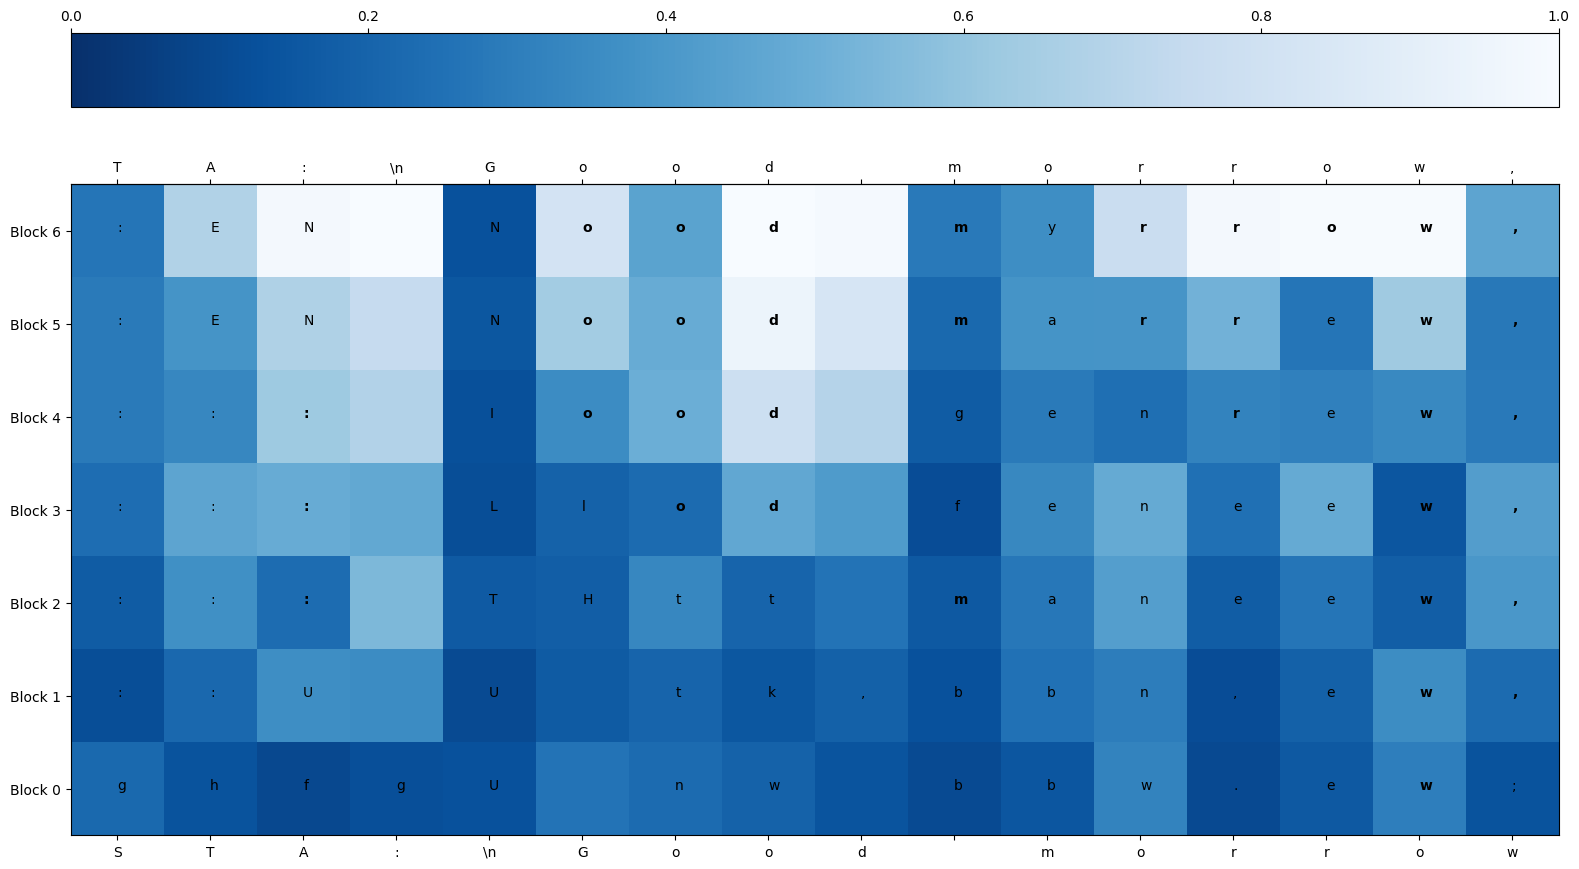

In [ ]:
def plot_logit_lens(input: torch.Tensor, correct: torch.Tensor):
    input_str, correct_str = decode(input.tolist()), decode(correct.tolist())

    top1_preds, top1_probs = logit_lens(input)

    # Reverse both results so that the last layer is at the top
    top1_preds.reverse()
    top1_probs.reverse()

    nx = len(input_str)
    ny = len(top1_preds)

    fig, ax = plt.subplots(1, 1, figsize=(1.2*nx, 20))
    im = ax.imshow(top1_probs, cmap='Blues_r')
    ax.set_xticks(range(len(input_str)))
    ax.set_xticklabels([repr(c)[1:-1] for c in input_str])

    ax.set_yticks(range(ny))
    ax.set_yticklabels([f"Block {i -1}" for i in range(ny, 0, -1)])
    
    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(range(len(input_str)))
    ax_top.set_xticklabels([repr(c)[1:-1] for c in correct_str])

    im.set_clim(vmin=0, vmax=1)
    plt.colorbar(im, ax=[ax], location='top')

    for y in range(ny):
        for x in range(nx):
            fontweight = 'bold' if top1_preds[y][x] == correct_str[x] else None
            plt.text(x, y, top1_preds[y][x], fontweight=fontweight)


input, correct = get_input_and_correct(val_data, start_idx=50)
plot_logit_lens(input, correct)

In [ ]:
idx = torch.stack([input])
idx = idx[:, -block_size:]

# Logic from the model's forward() function
B, T = idx.shape

assert B == 1 # for this analysis, going to assume just 1 batch

token_emb = m.token_embedding_table(idx)
pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
x = token_emb + pos_emb
x, intermediates = blocks(x) 


x = m.ln_f(x)
logits = m.lm_head(x)
top1 = torch.argmax(logits, dim=-1, keepdim=False)
top1

tensor([[ 1, 58, 53, 56, 58, 47, 57, 58, 39,  1,  0,  0, 23, 30, 30, 32]])

In [ ]:
# End of logit lens experiment

In [ ]:
# start trying to project singular vectors


In [ ]:
n_directions = 20
k = 5
block_idx = 3

w_in_matrix = m.blocks[block_idx].ffwd.net[0].weight.data
U, S, V = torch.linalg.svd(w_in_matrix, full_matrices=False)

V = V[:n_directions, :]
V = m.ln_f(V)
logits = m.lm_head(V)
logits.size()
topk = torch.topk(logits, k=k, dim=1, sorted=True).indices

results = [
    decode(topk[i, :].tolist())
    for i in range(n_directions)
]
results

['st ni',
 '.:;!,',
 'oaiez',
 ' e\ngu',
 'CltcN',
 ",' e;",
 "htH'l",
 'kdwFt',
 'hilwy',
 "oi'au",
 'RSMEI',
 'nmuvb',
 'dmyGb',
 'twTau',
 'kpser',
 'dhlfg',
 'LhFPp',
 'qtgnm',
 "emfs'",
 'dwFvb']

In [ ]:
# find i such that sum(S[:i]) >= 0.99*sum(S)

i=375
sum(S[:i]) / sum(S)

# So you need 375/384 directions, hmmm.

tensor(0.9908)

In [ ]:
def topk_tokens(logits: torch.Tensor, k: int=5):
    """Returns the top k tokens from a tensor of logits. 
    
    Parameters
    ----------
    logits:
        Tensor containing logits. Dimension should be (N, vocab_size). 
    
    k:
        How many tokens to return
    
    Returns
    -------
    Iterable[str]
        An iterable of N k-length strings, containing the top tokens in order.
    """
    n, _ = logits.shape 

    topk = torch.topk(logits, k=k, dim=1, sorted=True).indices

    results = [
        decode(topk[i, :].tolist())
        for i in range(n)
    ]
    return results


In [ ]:
# singular vectors for the MLP layer
def singular_vectors_mlp(m: TransformerLanguageModel, block_idx: int=0, k: int=5, n_directions: int=20):
    w_in_matrix = m.blocks[block_idx].ffwd.net[0].weight.data
    U, S, V = torch.linalg.svd(w_in_matrix, full_matrices=False)

    V = V[:n_directions, :]
    V = m.ln_f(V)
    logits = m.lm_head(V)

    return topk_tokens(logits, k=k)

singular_vectors_mlp(m, block_idx=3, k=15, n_directions=20)

['st niledrca,mo:',
 ".:;!,?-\n'X3$s&S",
 'oaiezyucxYOAbEg',
 " e\ngu-yO.i';RoB",
 'CltcNOLJGyAKTRB',
 ",' e;!vydaw.-?:",
 "htH'lINAkUDsnw,",
 'kdwFtgObuDyVWMj',
 "hilwyetrHs ,c'!",
 "oi'auryELnhJNl.",
 'RSMEIi:mGHBpNAJ',
 "nmuvbptzgMfrcl'",
 "dmyGbILRrilWD'g",
 "twTauCRo, cIr'N",
 'kpsernodDcmSThb',
 'dhlfgVceFkBnpCm',
 "LhFPpSNIT'VJKCO",
 'qtgnmxsrcRBGadX',
 "emfs'oz3n!xUi;,",
 'dwFvbSYHpTC\nWjI']

In [ ]:
# singular vectors for OV circuit

def singular_vectors_OV(m: TransformerLanguageModel,, head_idx: int=3, k: int=5, n_directions: int=20):
    # Get the V matrix from the block/head
    v = m.blocks[block_idx].sa.heads[head_idx].value.weight.data.detach() # n_embed x head_size

    # Get the O (projection) matrix from the block
    o = m.blocks[block_idx].sa.proj # n_embed x n_embed
    o_weight = o.weight.data.detach() # n_embed x n_embed
    o_bias = o.bias.data.detach()

    # Get the subset of the proj matrix that applies to this head
    o_weight_head = o_weight.reshape(n_embed, n_head, n_embed // n_head)[:, head_idx, :]
    o_weight_head.shape, v.shape

    # Do W_O @ V + bias
    out = o_weight_head @ v + o_bias

    # Do the SVD business
    U, S, V = torch.linalg.svd(out, full_matrices=False)

    V = V[:n_directions, :]
    V = m.blocks[block_idx].ln2(V) # Apply layer norm from the block

    logits = m.lm_head(m.ln_f(V))

    return topk_tokens(logits, k=k)

singular_vectors_OV(m, block_idx=5, head_idx=3, k=5, n_directions=20)


['Jzbc3',
 'o\nl r',
 'Q;, x',
 'xvuk3',
 '-\nNl ',
 'sprvg',
 'imqJ ',
 "hf'v?",
 'lxvs!',
 'SRFBD',
 'KHmCl',
 'ihWwc',
 'nel:t',
 'otedg',
 "etuc'",
 'OZISE',
 'dGDso',
 ':?wrm',
 'mnf s',
 'hkdes']

In [ ]:
def df_heads(m: TransformerLanguageModel, block_idx: int=0):
    data = [
        singular_vectors_OV(m, block_idx=block_idx, head_idx=h, k=10, n_directions=20)
        for h in range(n_head)
    ]
    return pd.DataFrame(data, index=[f'Head {h}' for h in range(n_head)])

In [ ]:
df_heads(m, block_idx=0)

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5
0,"sYNnrl.U,:",qvaVduiPXm,qvaVduiPCX,qvaVduiPXC,qvaVduiPXC,qvaVduiPCm
1,iLRoEMrTtG,iLmoAztRhe,"aeiy\n!-o.,",trngblcvIk,RimGoLzArK,iLrRomzutG
2,:TSoetUsMi,nXPRcNfgk?,AobsmeUBdr,PaImM.ZKCA,ye\ni-'o. !,wBtbczdrlg
3,omde!zV-as,b'rtnvzwsl,LRhyqGHNEk,zemwbI$GOp,":tls p.,;-",QX$'Zkzdyj
4,eiy \nE!I.-,yuoaKe&i\nH,bgqr$V?apf,oeaniusp r,OoIuYptmaz,LH.ygui?aG
5,'leai-:&Uz,Vpyj'fvhai,e'sEiaco-g,":;,\n.!? -o","duftXLv$m,",siuAaUpmkh
6,"daoe, mis-",ryPIiwebJG,"'ly,u?!med",'Kydear\nJz,lAZpHQitXg,ftysdiabmp
7,"lri uft,:E",lhtgpvxbya,JPNYFWpxSB,sz'rIwuoFn,"-\n,d.!;k A",":;,vKa.e?&"
8,telnuriaTy,"'-ps!vd, o",ptizQaYMlG,Xqcw\nu-v z,"iT ,n?.Jtg","l ?,a.-:;i"
9,LoVrBNa&ZP,d-\nGxncus$,VyI'gl&ATB,ie-'wnuh?,":eNdh!,A'U","svSlid:Me,"


In [ ]:
df_heads(m, block_idx=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Head 0,"sYNnrl.U,:",iLRoEMrTtG,:TSoetUsMi,omde!zV-as,eiy \nE!I.-,'leai-:&Uz,"daoe, mis-","lri uft,:E",telnuriaTy,LoVrBNa&ZP,tvSOiLdaos,ndyfoievuS,",rysflwd'",RFfMbtvgVK,"g s?i,oFe;",:Isua!eCAb,dEBsmADCRM,eliC\nkcvI',DLyJu!QBN\n,fygs urPD-
Head 1,qvaVduiPXm,iLmoAztRhe,nXPRcNfgk?,b'rtnvzwsl,yuoaKe&i\nH,Vpyj'fvhai,ryPIiwebJG,lhtgpvxbya,"'-ps!vd, o",d-\nGxncus$,"w\nYm,hTWs","zgPNp,K:Gn",zsGwPxBRAC,ruelaoiy.?,VMAoyBhWDk,"hbzn,u!g;?",abhxenor!i,aoKTlkeIrY,"-z:m\n;,st",mybvkidt's
Head 2,qvaVduiPCX,"aeiy\n!-o.,",AobsmeUBdr,LRhyqGHNEk,bgqr$V?apf,e'sEiaco-g,"'ly,u?!med",JPNYFWpxSB,ptizQaYMlG,VyI'gl&ATB,"F l,ri\n.'y",ujoEVlOCUq,MhZCHiTjIA,lqTsYxNGBE,dqbmkyjeva,",;:!. wIlO",IpiKEoubjy,HlyiBICgo,XWzFaQpkMN,"oal e-u,iy"
Head 3,qvaVduiPXC,trngblcvIk,PaImM.ZKCA,zemwbI$GOp,oeaniusp r,":;,\n.!? -o",'Kydear\nJz,sz'rIwuoFn,Xqcw\nu-v z,ie-'wnuh?,tRond: v'l,ACygzwtfiU,ybipmuktMU,C-tMlHszLT,lOtJ zFmRs,lyxurJRNHX,meo:;XiwA.,noE'wgfjst,"lsi.;e,' f",es ialrcth
Head 4,qvaVduiPXC,RimGoLzArK,ye\ni-'o. !,":tls p.,;-",OoIuYptmaz,"duftXLv$m,",lAZpHQitXg,"-\n,d.!;k A","iT ,n?.Jtg",":eNdh!,A'U",yek'?JEQWM,"xa,nlosv'r",yeh-biasBE,gtDqcYkpPm,C-kTdKgF;V,nlheas'yi,S!c:HCtDL&,iyrRbauGl,StX'qsTNMJ,"ery!h.im,t"
Head 5,qvaVduiPCm,iLrRomzutG,wBtbczdrlg,QX$'Zkzdyj,LH.ygui?aG,siuAaUpmkh,ftysdiabmp,":;,vKa.e?&","l ?,a.-:;i","svSlid:Me,",camyekrUt,-tnscOhb g,"tiseT'gl,",yIrHEpuMKl,\nIGD:Liy3Y,:Yjiek-bcm,"'dkts, .fh","e\n?!y i,.;",gbtp' nSTd,inwRherazo


In [ ]:
x.reshape(6, 2, 3)[:, 0, :]

tensor([[ 0,  1,  2],
        [ 6,  7,  8],
        [12, 13, 14],
        [18, 19, 20],
        [24, 25, 26],
        [30, 31, 32]])

In [ ]:
# end trying to project singular vectors

# Learning final embeddings for tokens

In [ ]:
def final_embedding_for_char(
    target_char: str, 
    lm_head_weights: torch.Tensor,
    lm_head_bias: torch.Tensor, 
    learning_rate: float = 3e-4,
    max_iters: int = 50000,
    device: str = device,
) -> torch.Tensor:
    """Given a character, learns the embedding that,
    when given as input to the `lm_head` linear layer at
    the end of the transformer, produces the logits select
    that character with probability almost 1."""
    assert len(target_char) == 1
    target = torch.tensor(encode(target_char)[0], device=device)

    # Create the lm_head layer with the given weights and bias.
    lm_head = nn.Linear(n_embed, vocab_size)
    with torch.no_grad():
        lm_head.weight = nn.Parameter(lm_head_weights.detach())
        lm_head.bias = nn.Parameter(lm_head_bias.detach())
    lm_head.to(device)

    lsfm = nn.LogSoftmax(dim=-1)
    lsfm.to(device)

    x = torch.nn.Parameter(torch.randn(n_embed), requires_grad=True).to(device)

    optimizer = torch.optim.AdamW([x], lr=learning_rate)
    eval_iters = max_iters // 10  

    print(f"Optimizing embedding for {repr(target_char)}")
    for step in range(max_iters):
        yhat = lsfm(lm_head(x))
        loss = F.nll_loss(yhat, target)

        if torch.isclose(loss, torch.tensor(0, dtype=loss.dtype, device=device)).item():
            print(f"ending training at step {step}: loss {loss.item():.4f}")
            break 

        if step % eval_iters == 0:
            print(f"step {step}: loss {loss.item():.4f}")

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return x.data.detach(), loss

In [ ]:
# Create a dictionary of the embeddings learned for each character
char_to_embedding = {
    c: final_embedding_for_char(
        target_char=c, 
        lm_head_weights=m.lm_head.weight.data.detach(),
        lm_head_bias=m.lm_head.bias.data.detach(),
    )[0]
    for c in chars
}

Optimizing embedding for '\n'
step 0: loss 5.6003
step 5000: loss 0.0161
step 10000: loss 0.0012
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 29156: loss 0.0000
Optimizing embedding for ' '
step 0: loss 3.2772
step 5000: loss 0.0124
step 10000: loss 0.0009
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 27694: loss 0.0000
Optimizing embedding for '!'
step 0: loss 5.5344
step 5000: loss 0.0145
step 10000: loss 0.0011
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 27042: loss 0.0000
Optimizing embedding for '$'
step 0: loss 4.9751
step 5000: loss 0.0180
step 10000: loss 0.0014
step 15000: loss 0.0001
step 20000: loss 0.0000
step 25000: loss 0.0000
step 30000: loss 0.0000
ending training at step 30098: loss 0.0000
Optimizing embedding for '&'
step 0: loss 4.8747
step 5000: loss 0.0220
step 10000: loss 0.0016
step 15000: loss 0.0001
step 20000:

In [ ]:
# Save char to embedding as json file
c2e_list = {
    c: embed.tolist()
    for c, embed in char_to_embedding.items()
}
Path('./char_to_embed.json').write_text(json.dumps(c2e_list, indent=2))

In [ ]:
# Load char to embedding from json file

c2e_json = json.loads(Path('./char_to_embed.json').read_text())
c2e_loaded = {
    c: torch.tensor(emb_list, dtype=torch.float32, device=device)
    for c, emb_list in c2e_json.items()
}

In [ ]:
# assert that loaded version is the same as the learned one
for c in char_to_embedding.keys():
    if not torch.allclose(char_to_embedding[c], c2e_loaded[c]):
        print(f"value for {c} is not close")

In [ ]:
char_to_embedding = c2e_loaded

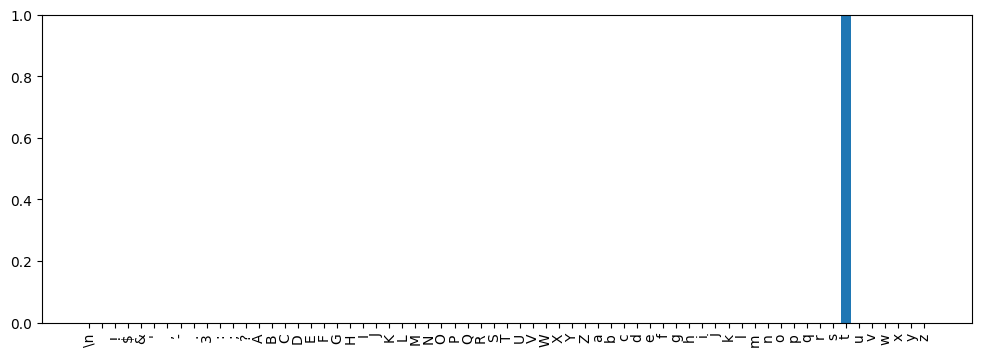

In [ ]:
# Show that a given embedding produces the expected probability distribution:
plot_probs(probs((char_to_embedding['t']).unsqueeze(dim=0).unsqueeze(dim=0))[0])

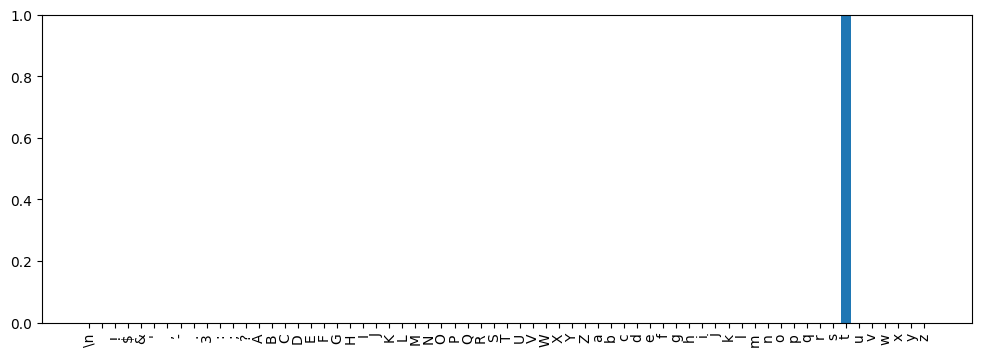

In [ ]:
# But, it turns out, so does that embedding times some scalar
plot_probs(probs((0.005*char_to_embedding['t']).unsqueeze(dim=0).unsqueeze(dim=0))[0])

In [ ]:
# So the learned embeddings might be all over the place in terms of magnitude

for c, emb in char_to_embedding.items():
    print(f"{c}: magnitude {torch.norm(emb):.3f}")


: magnitude 30.617
 : magnitude 30.902
!: magnitude 29.897
$: magnitude 33.369
&: magnitude 35.066
': magnitude 27.361
,: magnitude 37.357
-: magnitude 29.286
.: magnitude 39.026
3: magnitude 31.602
:: magnitude 29.694
;: magnitude 43.847
?: magnitude 30.283
A: magnitude 28.367
B: magnitude 30.993
C: magnitude 30.241
D: magnitude 27.405
E: magnitude 26.379
F: magnitude 29.955
G: magnitude 29.003
H: magnitude 30.564
I: magnitude 28.812
J: magnitude 32.213
K: magnitude 28.259
L: magnitude 26.740
M: magnitude 30.504
N: magnitude 26.946
O: magnitude 26.586
P: magnitude 30.202
Q: magnitude 34.560
R: magnitude 27.450
S: magnitude 29.542
T: magnitude 29.804
U: magnitude 26.477
V: magnitude 26.903
W: magnitude 31.263
X: magnitude 27.395
Y: magnitude 27.758
Z: magnitude 28.023
a: magnitude 28.811
b: magnitude 28.452
c: magnitude 27.551
d: magnitude 25.896
e: magnitude 27.376
f: magnitude 27.928
g: magnitude 26.272
h: magnitude 27.986
i: magnitude 28.046
j: magnitude 30.306
k: magnitude 25.228


Interesting that they're all between ~25-~40. But the difference in length may be why we can't make linear combinations and result in the expected probabilities

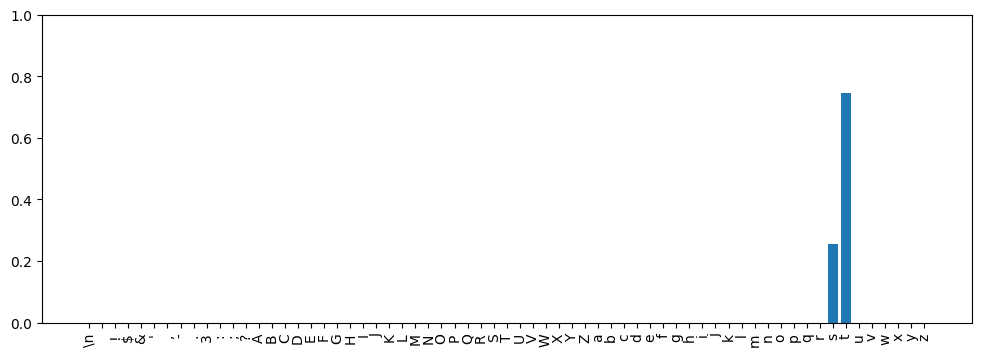

In [ ]:
# Linear combination doesn't produce equal probabilities
plot_probs(probs((0.5*char_to_embedding['t'] + 0.5*char_to_embedding['s']).unsqueeze(dim=0).unsqueeze(dim=0))[0])

# But that's weird because s and t are pretty close in magnitude (I picked those examples randomly)

In [ ]:
# Normalize them:
norm_char_to_embedding = {
    c: F.normalize(emb, dim=0, p=2)
    for c, emb in char_to_embedding.items()
}

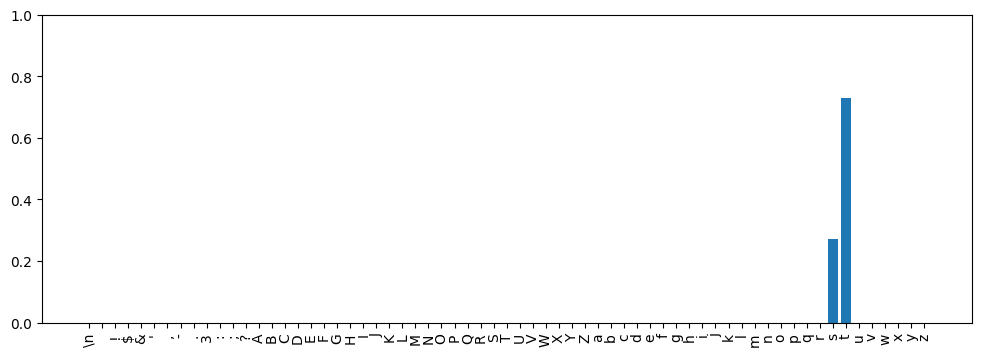

In [ ]:
plot_probs(probs((0.5*norm_char_to_embedding['t'] + 0.5*norm_char_to_embedding['s']).unsqueeze(dim=0).unsqueeze(dim=0))[0])

# Huh, this makes no difference

In [ ]:
cos = nn.CosineSimilarity(dim=-1)
cos(norm_char_to_embedding['s'], norm_char_to_embedding['t'])

# Thought they may be not that linearly independent. But looks like they are

tensor(0.0485)

In [ ]:
# The problem is likely that the output of the lm_head has different magnitudes for different tokens.
for c, emb in char_to_embedding.items():
    output = m.lm_head(emb)
    print(f"{c}: magnitude of output is {torch.norm(output):.3f}")


: magnitude of output is 25.753
 : magnitude of output is 39.040
!: magnitude of output is 24.102
$: magnitude of output is 25.197
&: magnitude of output is 26.708
': magnitude of output is 23.677
,: magnitude of output is 43.015
-: magnitude of output is 23.444
.: magnitude of output is 26.642
3: magnitude of output is 32.213
:: magnitude of output is 31.095
;: magnitude of output is 30.255
?: magnitude of output is 24.652
A: magnitude of output is 25.841
B: magnitude of output is 25.759
C: magnitude of output is 24.690
D: magnitude of output is 21.990
E: magnitude of output is 22.363
F: magnitude of output is 23.525
G: magnitude of output is 24.535
H: magnitude of output is 23.638
I: magnitude of output is 24.547
J: magnitude of output is 25.135
K: magnitude of output is 26.596
L: magnitude of output is 23.504
M: magnitude of output is 23.146
N: magnitude of output is 22.458
O: magnitude of output is 24.170
P: magnitude of output is 24.489
Q: magnitude of output is 27.425
R: magnitu

Yup, it's all over the place.


In [ ]:
# Let's scale the embeddings so they all have magnitude one

scale_char_to_embedding = {
    c: emb / torch.norm(m.lm_head(emb)).item()
    for c, emb in char_to_embedding.items()
}

In [ ]:
torch.norm(m.lm_head(char_to_embedding['c'])).item()

26.012086868286133

In [ ]:
torch.norm(m.lm_head(scale_char_to_embedding['c'])).item()

1.1794610023498535

In [ ]:
torch.norm(m.lm_head(scale_char_to_embedding['d'])).item()

1.2686735391616821

These are slightly different, likely due to the bias term. 

If 

$$
\|Wx + b\|_2 = m
$$

want to find $x'$ such that 

$$
\|Wx' + b\|_2 = 1
$$


... start of different approach ...


The output of `m.lm_head` (which is what these embeddings are inputs for), is

$$
Wx + b
$$

where $W$ and $b$ are the weights and biases of the lm_head layer respectively.

We want to find some scaling factor $\alpha$ such that 

$$
\|W({\alpha}x)\ + b\|_2 = 1
$$

Let

$$
v = Wx + b
$$

and

$$
\|v\|_2 = m
$$

Now scale $v$ to length 1, and call this new vector $u$:

$$
u = \frac{v}{m}
$$

If we had 

$$
W({\alpha}x)\ + b = u
$$

we'd be done because

$$
\|u\|_2 = 1
$$

So, we need to find $\alpha$ such that 

$$
W({\alpha}x) = u - b 
$$


In [ ]:
scale_char_to_embedding = {}

w = m.lm_head.weight.detach()
b = m.lm_head.bias.detach()

for c, emb in char_to_embedding.items():
    v = m.lm_head(emb) # Wx + b
    v_norm = torch.norm(v)
    alpha = ((v / v_norm) - b) / v 
    scale_char_to_embedding[c] = alpha[0] * emb 



In [ ]:
w = m.lm_head.weight.detach()
b = m.lm_head.bias.detach()
emb = char_to_embedding['c']
v = m.lm_head(emb) # Wx + b
v_norm = torch.norm(v)
alpha = ((v / v_norm) - b) / (w @ emb) 


In [ ]:
u = v / v_norm

In [ ]:
torch.norm(v * alpha)

tensor(1.0265, grad_fn=<LinalgVectorNormBackward0>)

Hmmm... this doesn't really work. Maybe can't just scale x by a linear factor:

$$
W(x + s) + b = u
$$

$$
Wx + Ws = u - b
$$

$$
Ws = u - b - Wx
$$

Can't solve for s directly, but can use [least squares](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) to approximate a solution

In [ ]:
B = (u - b - (w @ emb)).detach().numpy()
W = w.detach().numpy()

In [ ]:
S = np.linalg.lstsq(W, B, rcond=None)
S[0].shape

(384,)

In [ ]:
s = torch.tensor(S[0])
out = m.lm_head(emb + s)
torch.norm(out)

tensor(1.0000, grad_fn=<LinalgVectorNormBackward0>)

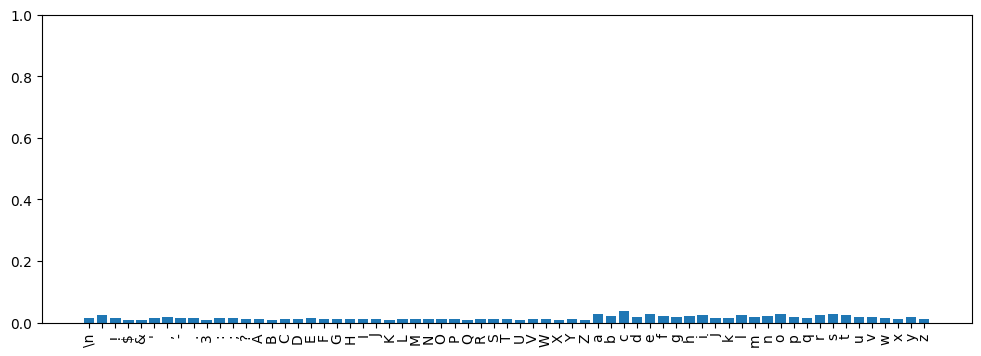

In [ ]:
new_emb = emb + s
plot_probs(probs((new_emb).unsqueeze(dim=0).unsqueeze(dim=0))[0])

Uh oh, this is not a good probability distribution. Thankfully, 'c' is still the max:

In [ ]:
itos[torch.argmax(probs((new_emb).unsqueeze(dim=0).unsqueeze(dim=0))[0]).item()]

'c'

but it's way too diffuse

In [ ]:
# Let's put this all into a single function: 

def scale_embedding(emb: torch.Tensor, want_out_norm: float=1.):
    w = m.lm_head.weight.detach()
    b = m.lm_head.bias.detach()

    v = m.lm_head(emb) # Wx + b
    v_norm = torch.norm(v)

    u = v / v_norm * want_out_norm

    s, _, _, _ = np.linalg.lstsq(w.detach().numpy(), (u - b - (w @ emb)).detach().numpy(), rcond=None)
    return emb + torch.tensor(s)


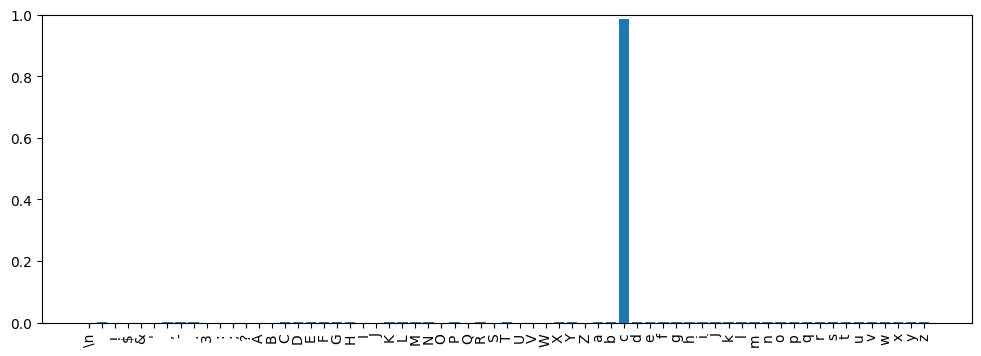

In [ ]:
plot_probs(probs((scale_embedding(char_to_embedding['c'], want_out_norm=10)).unsqueeze(dim=0).unsqueeze(dim=0))[0])

If we normalize magnitudes, can we do linear combinations?

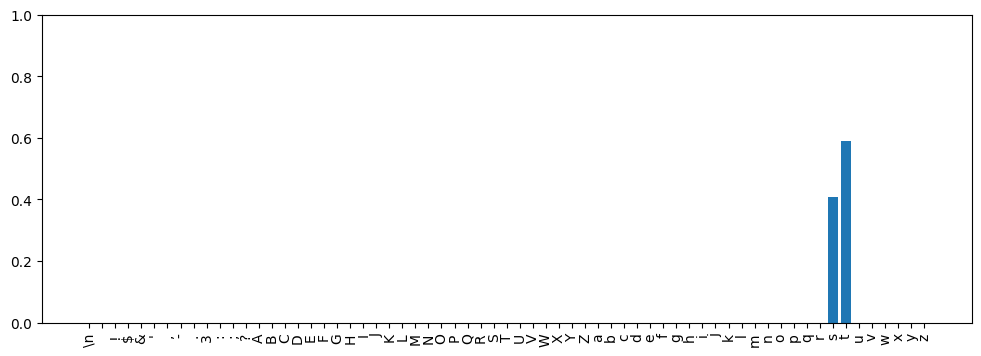

In [ ]:
emb_s = char_to_embedding['s']
emb_t = char_to_embedding['t']

def output_norm(x: torch.Tensor):
    x = m.ln_f(x)
    logits = m.lm_head(x)
    logits = logits[:, -1, :]

    return torch.norm(logits, dim=-1).item()

def scale_emb_to_match(target: torch.Tensor, emb: torch.Tensor):
    return scale_embedding(emb, output_norm(target))

def unsqueeze_emb(emb: torch.Tensor):
    return emb.unsqueeze(dim=0).unsqueeze(dim=0)

adj_emb_s = scale_emb_to_match(unsqueeze_emb(emb_t), emb_s)

plot_probs(probs((0.5*adj_emb_s + 0.5*emb_t).unsqueeze(dim=0).unsqueeze(dim=0))[0])


Still doesn't work. Something is wrong.

In [ ]:
print(output_norm(unsqueeze_emb(emb_s)))
print(output_norm(unsqueeze_emb(emb_t)))
print(output_norm(unsqueeze_emb(adj_emb_s)))

26.139930725097656
29.77330207824707
26.85598373413086


Uh-oh. The adjustment didn't have the desired effect. Wait, it's probably the layer norm:

In [ ]:
print(output_norm(unsqueeze_emb(scale_embedding(emb_s, 29.77))))
print(torch.norm(m.lm_head(scale_embedding(emb_s, 29.77))).item())
print(torch.norm(m.lm_head(m.ln_f(scale_embedding(emb_s, 29.77)))).item())

26.854820251464844
29.770000457763672
26.854820251464844


Confirmed. Middle one is without the layer norm and scales correctly. 

In [ ]:
# out of curiosity, what does the layer norm do to the direction? 

cos(m.lm_head(scale_embedding(emb_s, 29.77)), m.lm_head(m.ln_f(scale_embedding(emb_s, 29.77))))

tensor(0.9948, grad_fn=<SumBackward1>)

not much, apparently. But it is screwing up the ability to scale these things.

In [ ]:
# what are the parameters in the layernorm? 
x = emb_s 
m.ln_f(x) == m.ln_f.weight * x + m.ln_f.bias

print(m.ln_f(x)[0].item())
print((x)[0].item())
print(m.ln_f.weight[0].item())
print(m.ln_f.bias[0].item())


0.3656958043575287
0.2994629144668579
1.1173527240753174
0.02920062281191349


In [ ]:
# ooh per https://github.com/pytorch/pytorch/blob/392abde8e64b0d91b7d52aecee8dce9aff8d0b2f/aten/src/ATen/native/layer_norm.h#L61C1-L62C70 
# weight is gamma and beta is bias

def my_layernorm(x: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor):
    mean = x.mean()
    var = torch.var(x, unbiased=False)
    eps = 1e-05
    return ((x - mean) / torch.sqrt(var + eps)) * gamma + beta 

mine = my_layernorm(x, m.ln_f.weight, m.ln_f.bias)
theirs = m.ln_f(x)
torch.allclose(mine, theirs)

# ugh, can't invert layer norm because we don't know mean and var of the original vector

True

now let's scaling to whatever magnitude we get out of the real network and see how our alignment does


In [ ]:
# now let's scaling to whatever magnitude we get out of the real network and see how our alignment does




def compare_cosine_sims(to_char: str):
    cos = nn.CosineSimilarity(dim=-1)

    
    print(f"cos(h0_out, {to_char}) = {cos(h0_out[:, -1, :], scale_emb_to_match(h0_out, char_to_embedding[to_char])).item():.2f}")
    print(f"cos(h0h1_out, {to_char}) = {cos(h0h1_out[:, -1, :], scale_emb_to_match(h0h1_out, char_to_embedding[to_char])).item():.2f}")
    print(f"cos(h0h1h2_out, {to_char}) = {cos(h0h1h2_out[:, -1, :], scale_emb_to_match(h0h1h2_out, char_to_embedding[to_char])).item():.2f}")
    print(f"cos(h0h1h2h3_out, {to_char}) = {cos(h0h1h2h3_out[:, -1, :], scale_emb_to_match(h0h1h2h3_out, char_to_embedding[to_char])).item():.2f}")
    print(f"cos(h0h1h2h3h4_out, {to_char}) = {cos(h0h1h2h3h4_out[:, -1, :], scale_emb_to_match(h0h1h2h3h4_out, char_to_embedding[to_char])).item():.2f}")
    print(f"cos(h0h1h2h3h4h5_out, {to_char}) = {cos(h0h1h2h3h4h5_out[:, -1, :], scale_emb_to_match(h0h1h2h3h4h5_out, char_to_embedding[to_char])).item():.2f}")


compare_cosine_sims('z')

cos(h0_out, z) = 0.09
cos(h0h1_out, z) = 0.08
cos(h0h1h2_out, z) = 0.05
cos(h0h1h2h3_out, z) = 0.06
cos(h0h1h2h3h4_out, z) = 0.06
cos(h0h1h2h3h4h5_out, z) = 0.08


In [ ]:
compare_cosine_sims(':')

cos(h0_out, :) = -0.07
cos(h0h1_out, :) = 0.01
cos(h0h1h2_out, :) = 0.03
cos(h0h1h2h3_out, :) = 0.08
cos(h0h1h2h3h4_out, :) = 0.06
cos(h0h1h2h3h4h5_out, :) = 0.06


In [ ]:
compare_cosine_sims('s')

cos(h0_out, s) = 0.10
cos(h0h1_out, s) = 0.09
cos(h0h1h2_out, s) = 0.04
cos(h0h1h2h3_out, s) = 0.05
cos(h0h1h2h3h4_out, s) = -0.00
cos(h0h1h2h3h4h5_out, s) = 0.03


# Cosine similarity of final embeddings

In [ ]:
# Calculate similarities across all items
sims = np.zeros((vocab_size, vocab_size), dtype=np.float32)

cos = nn.CosineSimilarity(dim=-1)

for i in range(vocab_size):
    ci = itos[i]
    embi = char_to_embedding[ci]
    for j in range(vocab_size):
        cj = itos[j]
        embj = char_to_embedding[cj]
        sims[i][j] = cos(embi, embj).item()

    
        

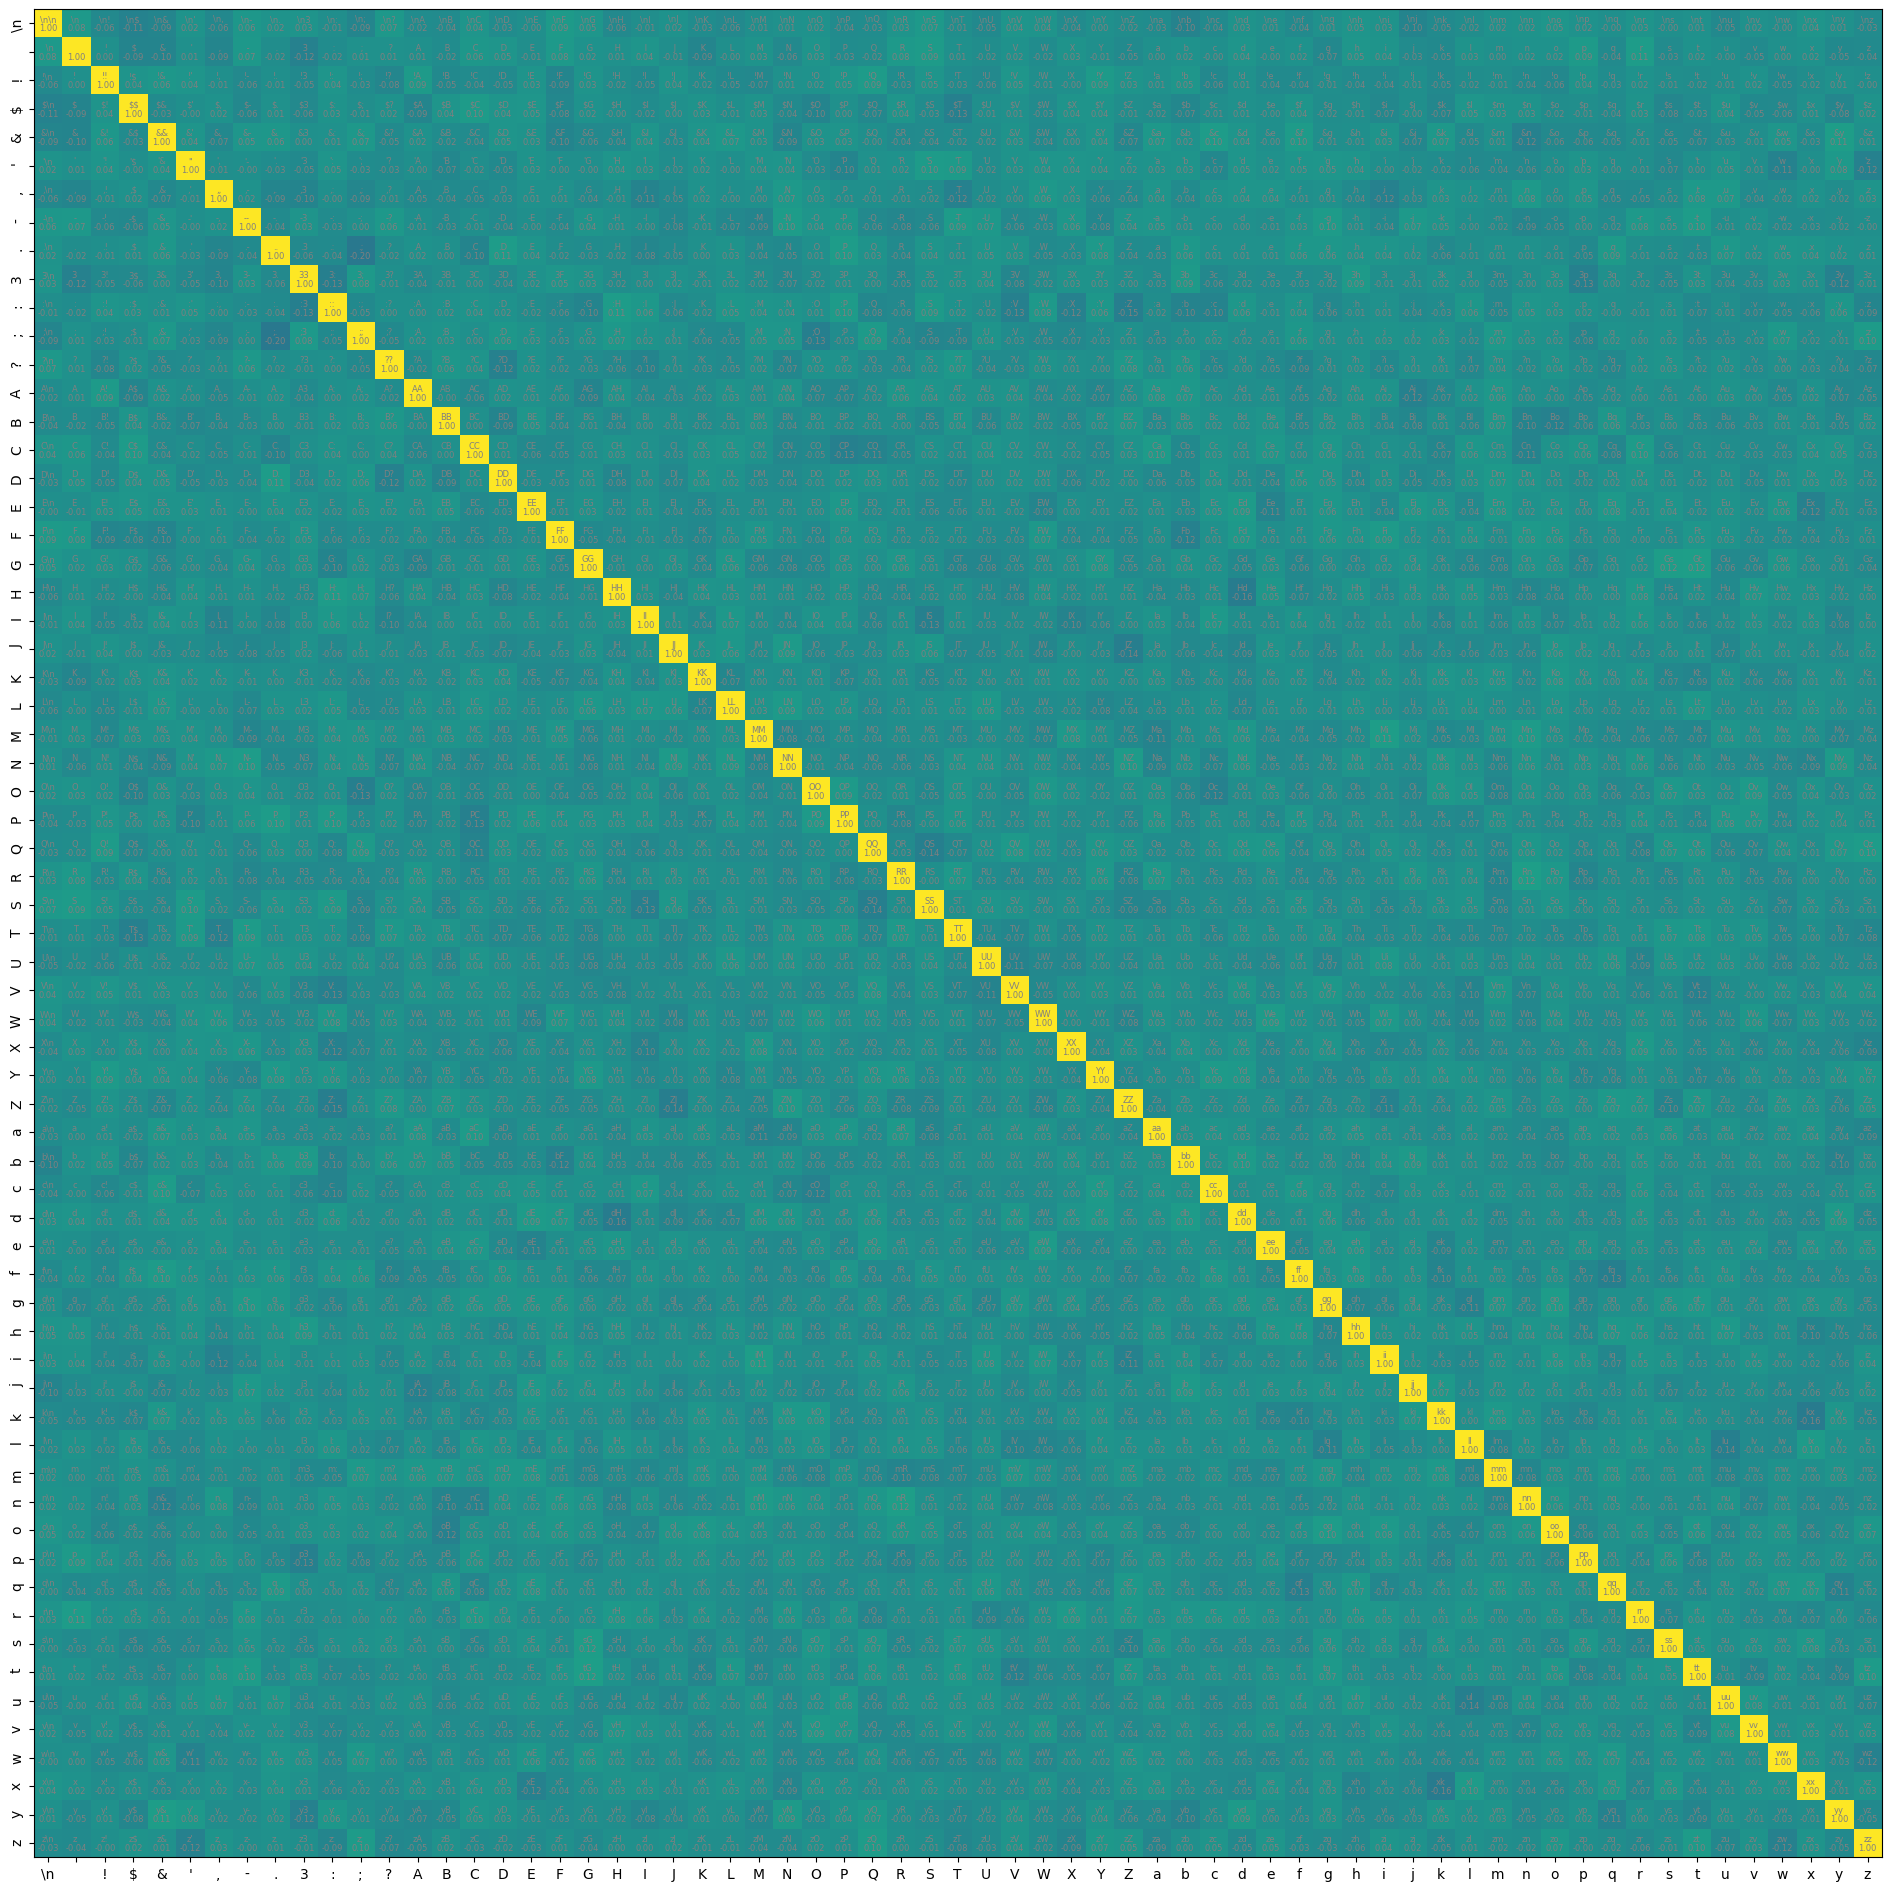

In [ ]:
# Plot cosine similarities
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
im = ax.imshow(sims, cmap='viridis', interpolation='none', vmin=-1, vmax=1)

char_labels = [repr(c)[1:-1] for c in chars]
ax.set_xticks(range(vocab_size))
ax.set_xticklabels(char_labels)
ax.set_yticks(range(vocab_size))
ax.set_yticklabels(char_labels, rotation='vertical')

for i in range(vocab_size):
    for j in range(vocab_size):
        seq = f'{repr(itos[i])[1:-1]}{repr(itos[j])[1:-1]}'

        if seq == '$$':
            seq = '\\$\\$' # special case https://github.com/matplotlib/matplotlib/issues/20266/#issuecomment-844462696
        plt.text(j, i, seq, ha='center', va='bottom', color='gray', fontsize=6)
        plt.text(j, i, f'{sims[i][j].item():.2f}', ha='center', va='top', color='gray', fontsize=6)


In [ ]:
mask = np.ones((vocab_size, vocab_size))
np.fill_diagonal(mask, 0) # put zeros in the diagonal

In [ ]:
# get the max of the masked values i.e. max among elements not on the diagonal
np.max(sims*mask)

0.12378747761249542

In [ ]:
# location of max element not on the diagonal
max_ind = np.unravel_index(np.argmax(sims*mask, axis=None), sims.shape)

In [ ]:
max_ind
(itos[max_ind[0]], itos[max_ind[1]])

('G', 't')

# Plot the actual final embeddings


In [ ]:
embs = torch.stack([
    char_to_embedding[itos[i]]
    for i in range(vocab_size)
])
embs = embs.detach().numpy()

In [ ]:
embs.shape

(65, 384)

[Text(0, 0, '\\n'),
 Text(0, 1, ' '),
 Text(0, 2, '!'),
 Text(0, 3, '$'),
 Text(0, 4, '&'),
 Text(0, 5, "'"),
 Text(0, 6, ','),
 Text(0, 7, '-'),
 Text(0, 8, '.'),
 Text(0, 9, '3'),
 Text(0, 10, ':'),
 Text(0, 11, ';'),
 Text(0, 12, '?'),
 Text(0, 13, 'A'),
 Text(0, 14, 'B'),
 Text(0, 15, 'C'),
 Text(0, 16, 'D'),
 Text(0, 17, 'E'),
 Text(0, 18, 'F'),
 Text(0, 19, 'G'),
 Text(0, 20, 'H'),
 Text(0, 21, 'I'),
 Text(0, 22, 'J'),
 Text(0, 23, 'K'),
 Text(0, 24, 'L'),
 Text(0, 25, 'M'),
 Text(0, 26, 'N'),
 Text(0, 27, 'O'),
 Text(0, 28, 'P'),
 Text(0, 29, 'Q'),
 Text(0, 30, 'R'),
 Text(0, 31, 'S'),
 Text(0, 32, 'T'),
 Text(0, 33, 'U'),
 Text(0, 34, 'V'),
 Text(0, 35, 'W'),
 Text(0, 36, 'X'),
 Text(0, 37, 'Y'),
 Text(0, 38, 'Z'),
 Text(0, 39, 'a'),
 Text(0, 40, 'b'),
 Text(0, 41, 'c'),
 Text(0, 42, 'd'),
 Text(0, 43, 'e'),
 Text(0, 44, 'f'),
 Text(0, 45, 'g'),
 Text(0, 46, 'h'),
 Text(0, 47, 'i'),
 Text(0, 48, 'j'),
 Text(0, 49, 'k'),
 Text(0, 50, 'l'),
 Text(0, 51, 'm'),
 Text(0, 52, 'n'),
 

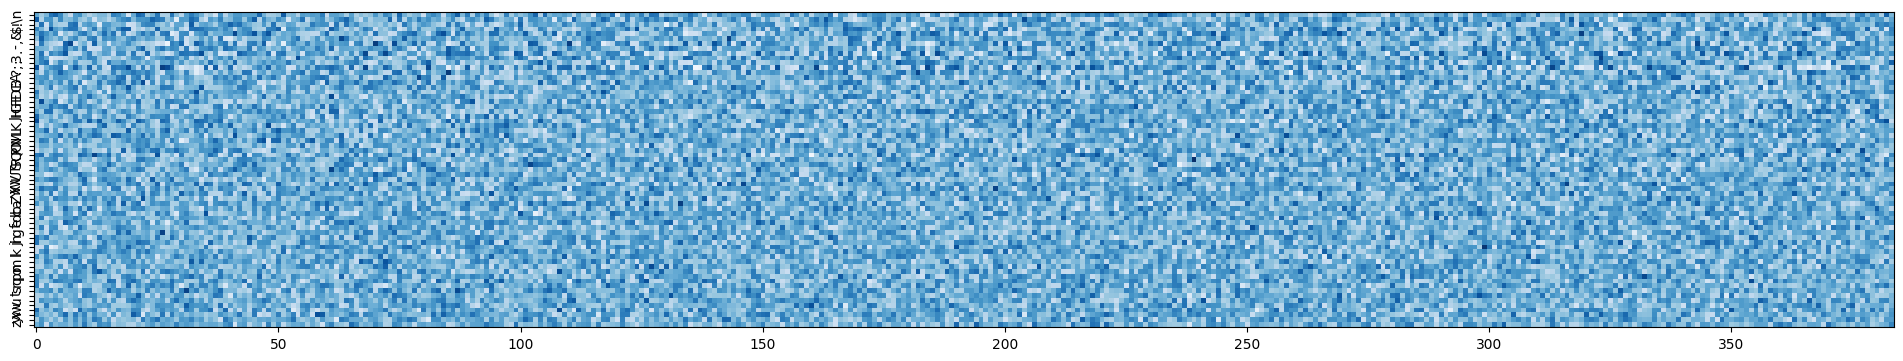

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24, 141))
im = ax.imshow(embs, cmap='Blues_r', interpolation='none')

char_labels = [repr(c)[1:-1] for c in chars]
ax.set_yticks(range(vocab_size))
ax.set_yticklabels(char_labels, rotation='vertical')



In [ ]:
embs

array([[-0.21139464,  1.3273716 ,  0.33567914, ...,  1.69717   ,
        -3.0985658 ,  0.38107866],
       [-3.3300498 ,  1.7564793 , -1.0586277 , ..., -0.907864  ,
         1.4445012 , -0.42874134],
       [ 1.8499137 , -2.4368188 ,  2.7802446 , ..., -1.4580238 ,
        -2.074943  , -1.1318239 ],
       ...,
       [-1.1144028 ,  0.43981186,  1.0150694 , ...,  1.2514385 ,
         0.21596012, -1.1458619 ],
       [ 1.3452995 , -1.0368049 ,  0.31945083, ...,  1.9752915 ,
        -0.81339324, -0.7974676 ],
       [ 0.04942426, -1.1837153 ,  2.5201893 , ...,  0.2613465 ,
        -0.09611028, -1.71054   ]], dtype=float32)

In [ ]:
np.min(embs)

-4.9901314

In [ ]:
max_ind

(19, 58)

[Text(0, 0, 'G'), Text(0, 1, 't')]

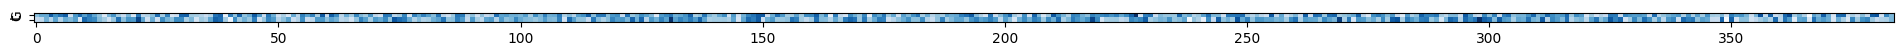

In [ ]:
# Plot the two lines with max cosine similarity
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
im = ax.imshow(embs[[19, 58], :], cmap='Blues_r', interpolation='none')

char_labels = ['G', 't']
ax.set_yticks([0, 1])
ax.set_yticklabels(char_labels, rotation='vertical')

In [ ]:
24 * 384/65

141.7846153846154

# SVD on all embeddings

In [ ]:
embs_tensor = torch.stack([
    char_to_embedding[itos[i]]
    for i in range(vocab_size)
])

In [ ]:
embs_tensor.shape

torch.Size([65, 384])

In [ ]:
U, S, V = torch.linalg.svd(embs_tensor, full_matrices=False)

In [ ]:
U.shape

torch.Size([65, 65])

In [ ]:
V.shape

torch.Size([65, 384])

In [ ]:
S.shape

torch.Size([65])

In [ ]:
S

tensor([47.9128, 42.8462, 40.4332, 39.4647, 38.1056, 37.6670, 36.7721, 35.9719,
        35.9069, 35.4360, 35.1619, 34.9209, 34.1377, 34.0540, 33.3566, 32.9835,
        32.5140, 32.4701, 32.1404, 32.0396, 31.7237, 31.3357, 31.1664, 30.9779,
        30.6018, 30.0182, 29.8089, 29.4549, 29.1628, 28.9065, 28.7674, 28.5049,
        28.2471, 28.0238, 27.7284, 27.2253, 26.9382, 26.7801, 26.5443, 26.3337,
        26.1642, 25.7672, 25.3905, 24.9440, 24.7525, 24.6896, 24.1155, 24.0000,
        23.8332, 23.4727, 22.9223, 22.8914, 22.4782, 22.2250, 21.5820, 21.4870,
        21.2020, 20.9352, 20.3066, 20.1159, 19.9390, 19.2638, 18.6247, 18.4554,
        17.3015])

In [ ]:
# find i such that sum(S[:i]) >= 0.99*sum(S)

i=64
sum(S[:i]) / sum(S)

# Hmm, need 63/65 directions.

tensor(0.9907)

In [ ]:
U

tensor([[-0.0990, -0.0469,  0.2630,  ...,  0.1125, -0.0010,  0.0466],
        [-0.0118, -0.0508,  0.2604,  ...,  0.1904, -0.0410,  0.0924],
        [-0.0236,  0.0505, -0.1297,  ...,  0.0196, -0.0984,  0.0456],
        ...,
        [-0.0356,  0.0095,  0.0122,  ..., -0.2088,  0.0764,  0.1092],
        [-0.0074,  0.0511, -0.1168,  ...,  0.2155,  0.2314,  0.2197],
        [ 0.0635,  0.0256, -0.0834,  ...,  0.0136, -0.3303,  0.2620]])

[Text(0, 0, '\\n'),
 Text(0, 1, ' '),
 Text(0, 2, '!'),
 Text(0, 3, '$'),
 Text(0, 4, '&'),
 Text(0, 5, "'"),
 Text(0, 6, ','),
 Text(0, 7, '-'),
 Text(0, 8, '.'),
 Text(0, 9, '3'),
 Text(0, 10, ':'),
 Text(0, 11, ';'),
 Text(0, 12, '?'),
 Text(0, 13, 'A'),
 Text(0, 14, 'B'),
 Text(0, 15, 'C'),
 Text(0, 16, 'D'),
 Text(0, 17, 'E'),
 Text(0, 18, 'F'),
 Text(0, 19, 'G'),
 Text(0, 20, 'H'),
 Text(0, 21, 'I'),
 Text(0, 22, 'J'),
 Text(0, 23, 'K'),
 Text(0, 24, 'L'),
 Text(0, 25, 'M'),
 Text(0, 26, 'N'),
 Text(0, 27, 'O'),
 Text(0, 28, 'P'),
 Text(0, 29, 'Q'),
 Text(0, 30, 'R'),
 Text(0, 31, 'S'),
 Text(0, 32, 'T'),
 Text(0, 33, 'U'),
 Text(0, 34, 'V'),
 Text(0, 35, 'W'),
 Text(0, 36, 'X'),
 Text(0, 37, 'Y'),
 Text(0, 38, 'Z'),
 Text(0, 39, 'a'),
 Text(0, 40, 'b'),
 Text(0, 41, 'c'),
 Text(0, 42, 'd'),
 Text(0, 43, 'e'),
 Text(0, 44, 'f'),
 Text(0, 45, 'g'),
 Text(0, 46, 'h'),
 Text(0, 47, 'i'),
 Text(0, 48, 'j'),
 Text(0, 49, 'k'),
 Text(0, 50, 'l'),
 Text(0, 51, 'm'),
 Text(0, 52, 'n'),
 

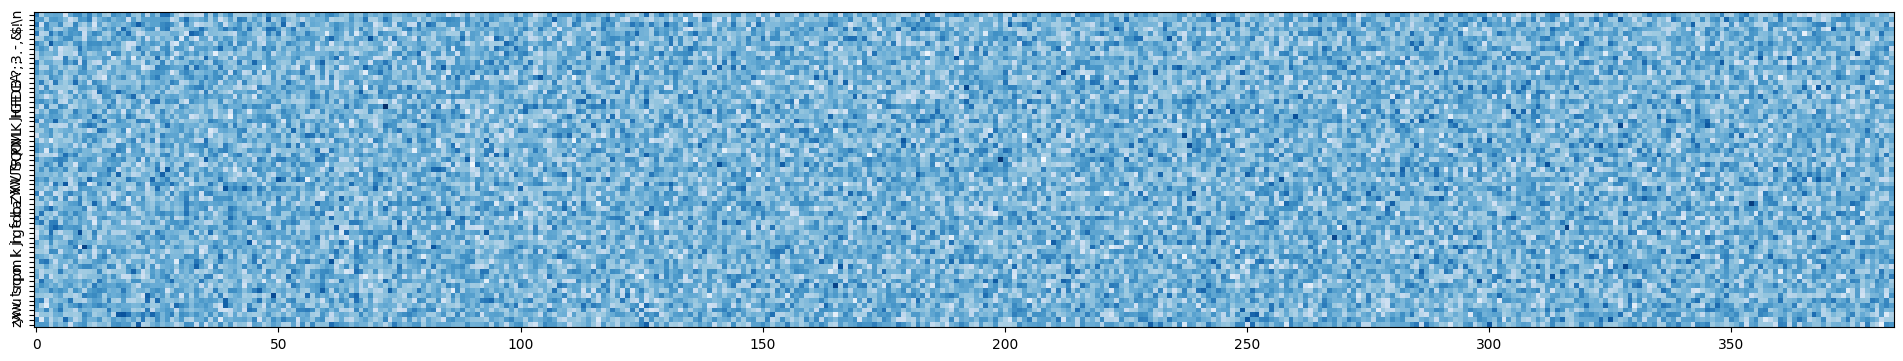

In [ ]:
# Plot V

fig, ax = plt.subplots(1, 1, figsize=(24, 141))
im = ax.imshow(V.detach().numpy(), cmap='Blues_r', interpolation='none')

char_labels = [repr(c)[1:-1] for c in chars]
ax.set_yticks(range(vocab_size))
ax.set_yticklabels(char_labels, rotation='vertical')

[Text(0, 0, '\\n'),
 Text(0, 1, ' '),
 Text(0, 2, '!'),
 Text(0, 3, '$'),
 Text(0, 4, '&'),
 Text(0, 5, "'"),
 Text(0, 6, ','),
 Text(0, 7, '-'),
 Text(0, 8, '.'),
 Text(0, 9, '3'),
 Text(0, 10, ':'),
 Text(0, 11, ';'),
 Text(0, 12, '?'),
 Text(0, 13, 'A'),
 Text(0, 14, 'B'),
 Text(0, 15, 'C'),
 Text(0, 16, 'D'),
 Text(0, 17, 'E'),
 Text(0, 18, 'F'),
 Text(0, 19, 'G'),
 Text(0, 20, 'H'),
 Text(0, 21, 'I'),
 Text(0, 22, 'J'),
 Text(0, 23, 'K'),
 Text(0, 24, 'L'),
 Text(0, 25, 'M'),
 Text(0, 26, 'N'),
 Text(0, 27, 'O'),
 Text(0, 28, 'P'),
 Text(0, 29, 'Q'),
 Text(0, 30, 'R'),
 Text(0, 31, 'S'),
 Text(0, 32, 'T'),
 Text(0, 33, 'U'),
 Text(0, 34, 'V'),
 Text(0, 35, 'W'),
 Text(0, 36, 'X'),
 Text(0, 37, 'Y'),
 Text(0, 38, 'Z'),
 Text(0, 39, 'a'),
 Text(0, 40, 'b'),
 Text(0, 41, 'c'),
 Text(0, 42, 'd'),
 Text(0, 43, 'e'),
 Text(0, 44, 'f'),
 Text(0, 45, 'g'),
 Text(0, 46, 'h'),
 Text(0, 47, 'i'),
 Text(0, 48, 'j'),
 Text(0, 49, 'k'),
 Text(0, 50, 'l'),
 Text(0, 51, 'm'),
 Text(0, 52, 'n'),
 

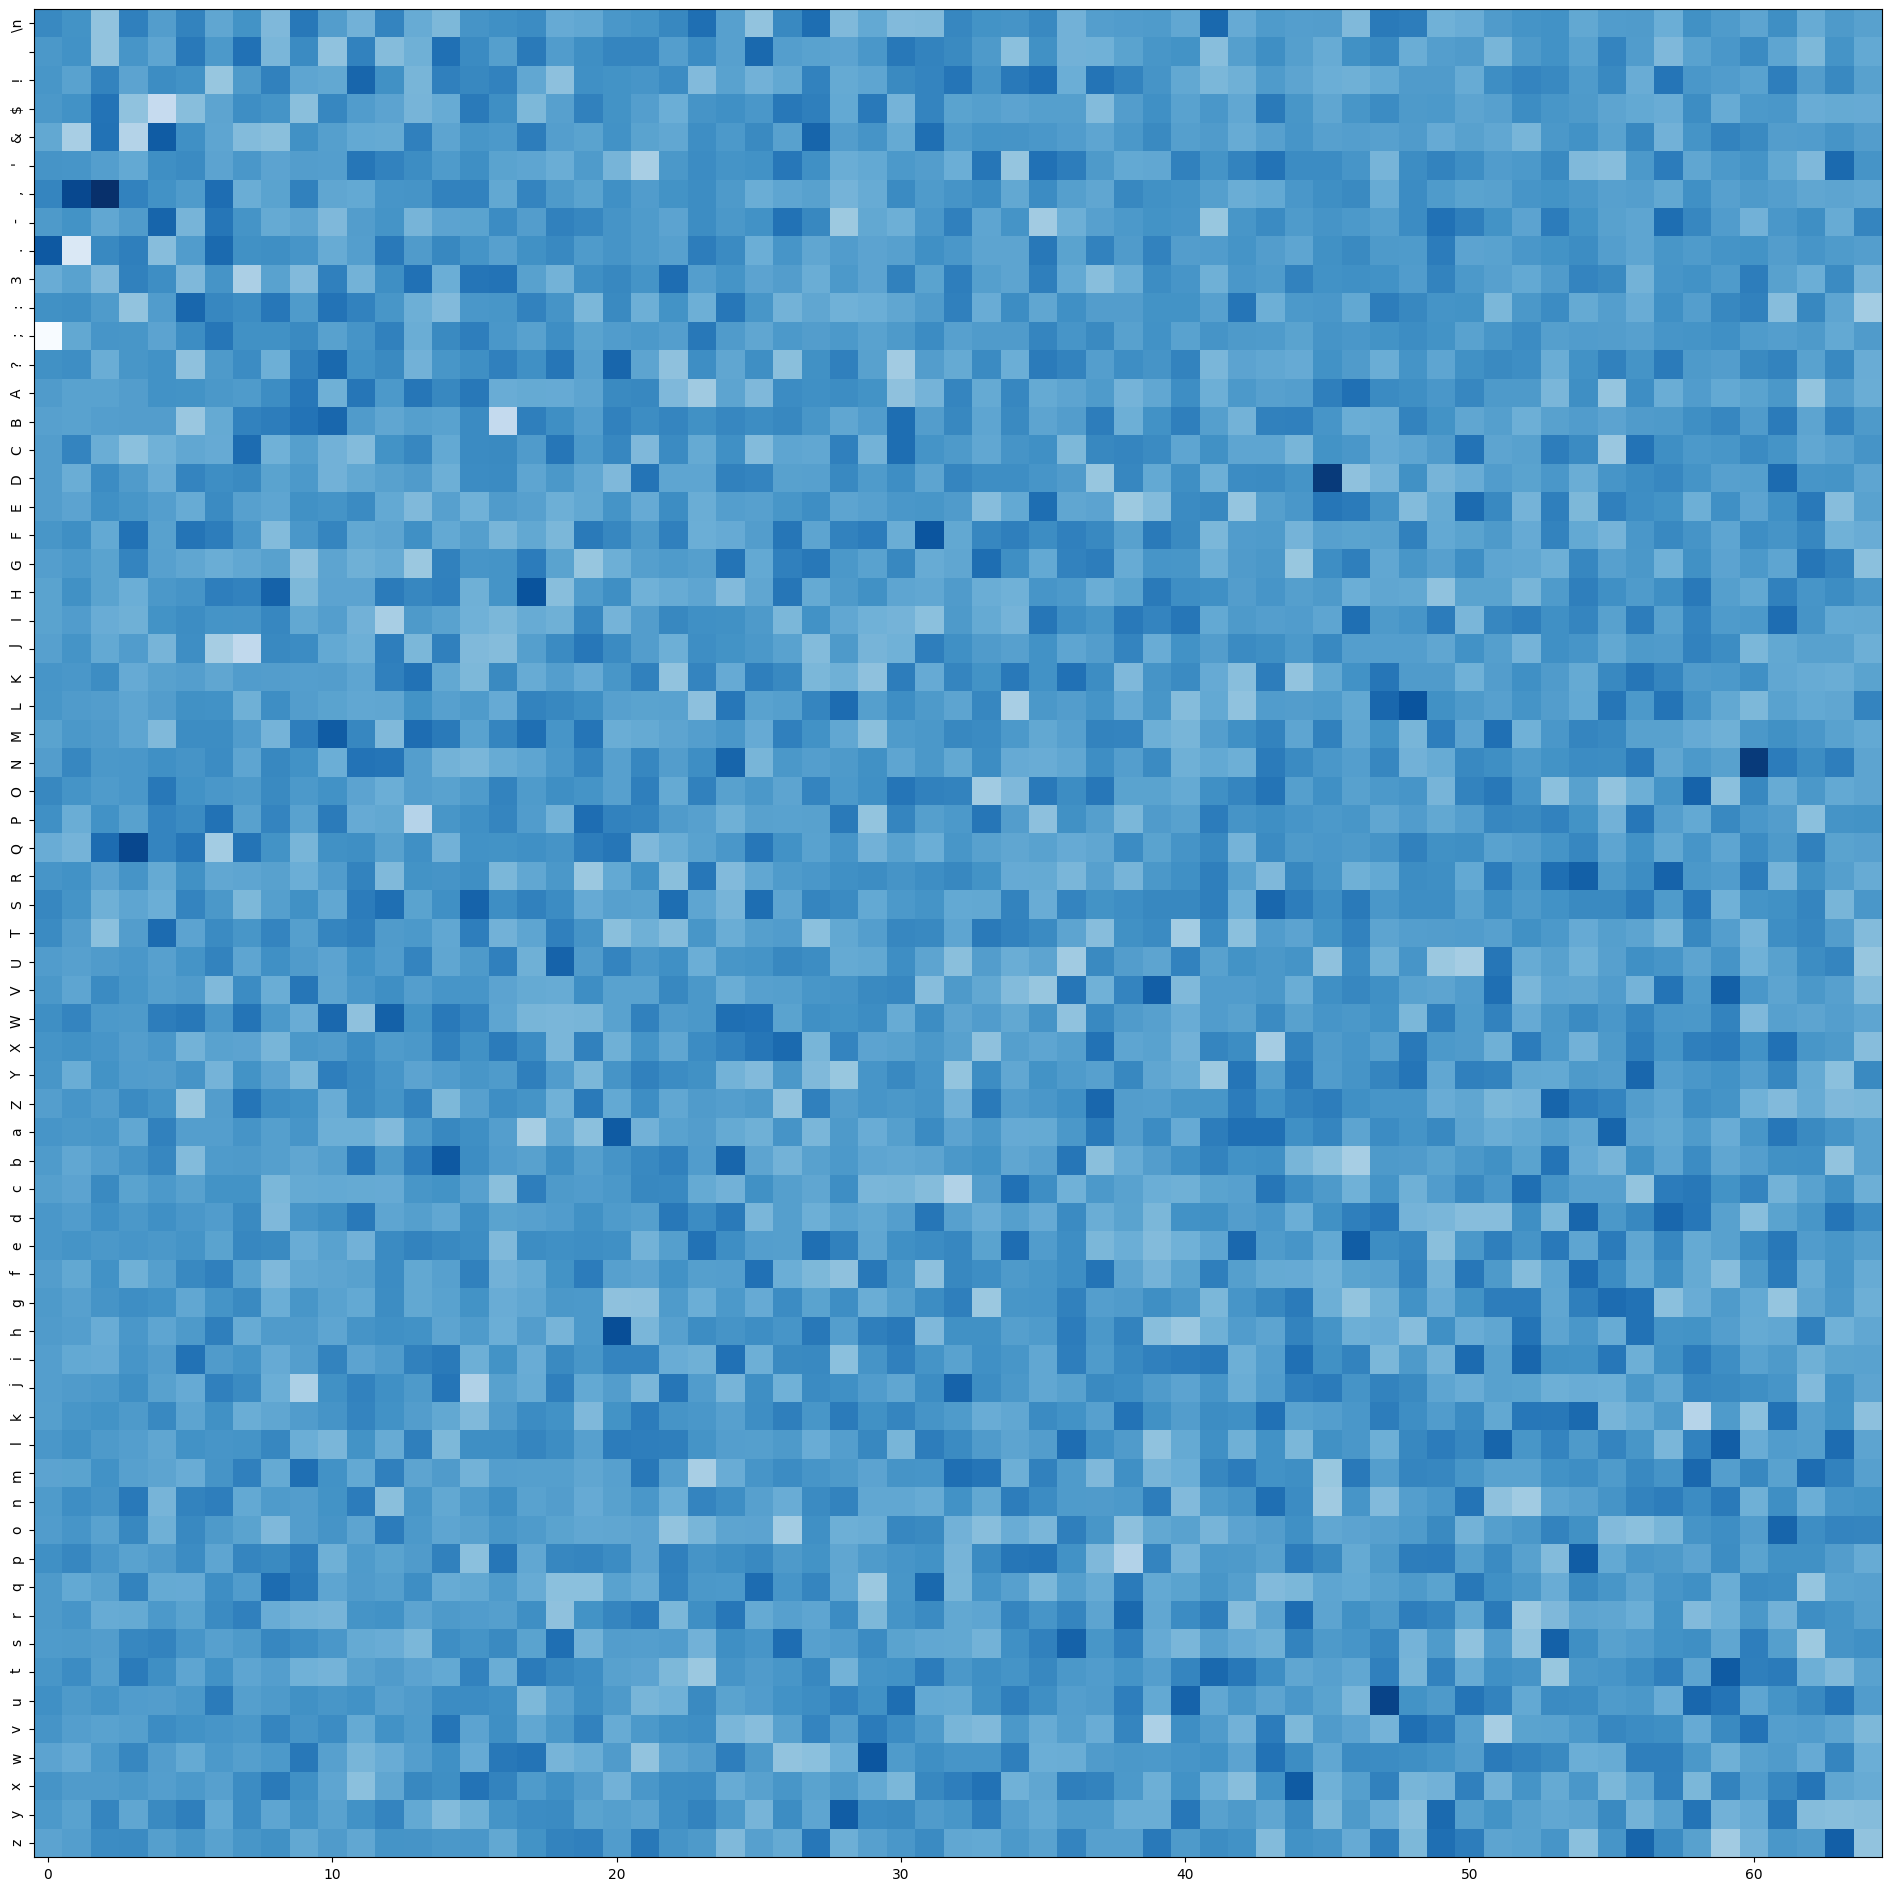

In [ ]:
# Plot U

fig, ax = plt.subplots(1, 1, figsize=(24, 24))
im = ax.imshow(U.detach().numpy(), cmap='Blues_r', interpolation='none')

char_labels = [repr(c)[1:-1] for c in chars]
ax.set_yticks(range(vocab_size))
ax.set_yticklabels(char_labels, rotation='vertical')

In [ ]:
torch.argmax(U[:,0])

tensor(11)

In [ ]:
torch.argmax(U, dim=0)

tensor([11,  8,  0,  4,  3, 38, 22, 22,  4, 48,  1, 35, 21, 28, 63, 48, 14, 39,
        56, 30, 45,  5, 53, 51, 30,  0, 53, 32,  7, 55, 12, 44, 41, 27, 24,  7,
        33, 16, 54, 60, 32, 37, 17, 36, 19, 52, 40, 52, 63, 33, 33, 60, 52, 58,
        64, 15, 41, 45, 49, 64, 49, 45, 57, 40, 10])

In [ ]:
uniq_max = set(torch.argmax(U, dim=0).tolist())

In [ ]:
len(uniq_max)

45

In [ ]:
torch.max(U[:, 0])

tensor(0.8420)

In [ ]:
sorted, indices = torch.sort(torch.argmax(U, dim=0))

In [ ]:
indices

tensor([25,  2, 10,  4,  8,  3, 21, 28, 35,  1, 64,  0, 30, 16, 55, 37, 42, 44,
        12,  6,  7, 34, 33, 13, 19, 24, 27, 40, 50, 49, 36, 11, 43, 41,  5, 17,
        63, 46, 32, 56, 31, 61, 57, 20, 15,  9, 58, 60, 23, 45, 47, 52, 26, 22,
        38, 29, 18, 62, 53, 39, 51, 14, 48, 59, 54])

In [ ]:
maxes = torch.argmax(U, dim=0)


In [ ]:
U_inorder = torch.index_select(U, dim=1, index=indices)

[Text(0, 0, '\\n'),
 Text(0, 1, ' '),
 Text(0, 2, '!'),
 Text(0, 3, '$'),
 Text(0, 4, '&'),
 Text(0, 5, "'"),
 Text(0, 6, ','),
 Text(0, 7, '-'),
 Text(0, 8, '.'),
 Text(0, 9, '3'),
 Text(0, 10, ':'),
 Text(0, 11, ';'),
 Text(0, 12, '?'),
 Text(0, 13, 'A'),
 Text(0, 14, 'B'),
 Text(0, 15, 'C'),
 Text(0, 16, 'D'),
 Text(0, 17, 'E'),
 Text(0, 18, 'F'),
 Text(0, 19, 'G'),
 Text(0, 20, 'H'),
 Text(0, 21, 'I'),
 Text(0, 22, 'J'),
 Text(0, 23, 'K'),
 Text(0, 24, 'L'),
 Text(0, 25, 'M'),
 Text(0, 26, 'N'),
 Text(0, 27, 'O'),
 Text(0, 28, 'P'),
 Text(0, 29, 'Q'),
 Text(0, 30, 'R'),
 Text(0, 31, 'S'),
 Text(0, 32, 'T'),
 Text(0, 33, 'U'),
 Text(0, 34, 'V'),
 Text(0, 35, 'W'),
 Text(0, 36, 'X'),
 Text(0, 37, 'Y'),
 Text(0, 38, 'Z'),
 Text(0, 39, 'a'),
 Text(0, 40, 'b'),
 Text(0, 41, 'c'),
 Text(0, 42, 'd'),
 Text(0, 43, 'e'),
 Text(0, 44, 'f'),
 Text(0, 45, 'g'),
 Text(0, 46, 'h'),
 Text(0, 47, 'i'),
 Text(0, 48, 'j'),
 Text(0, 49, 'k'),
 Text(0, 50, 'l'),
 Text(0, 51, 'm'),
 Text(0, 52, 'n'),
 

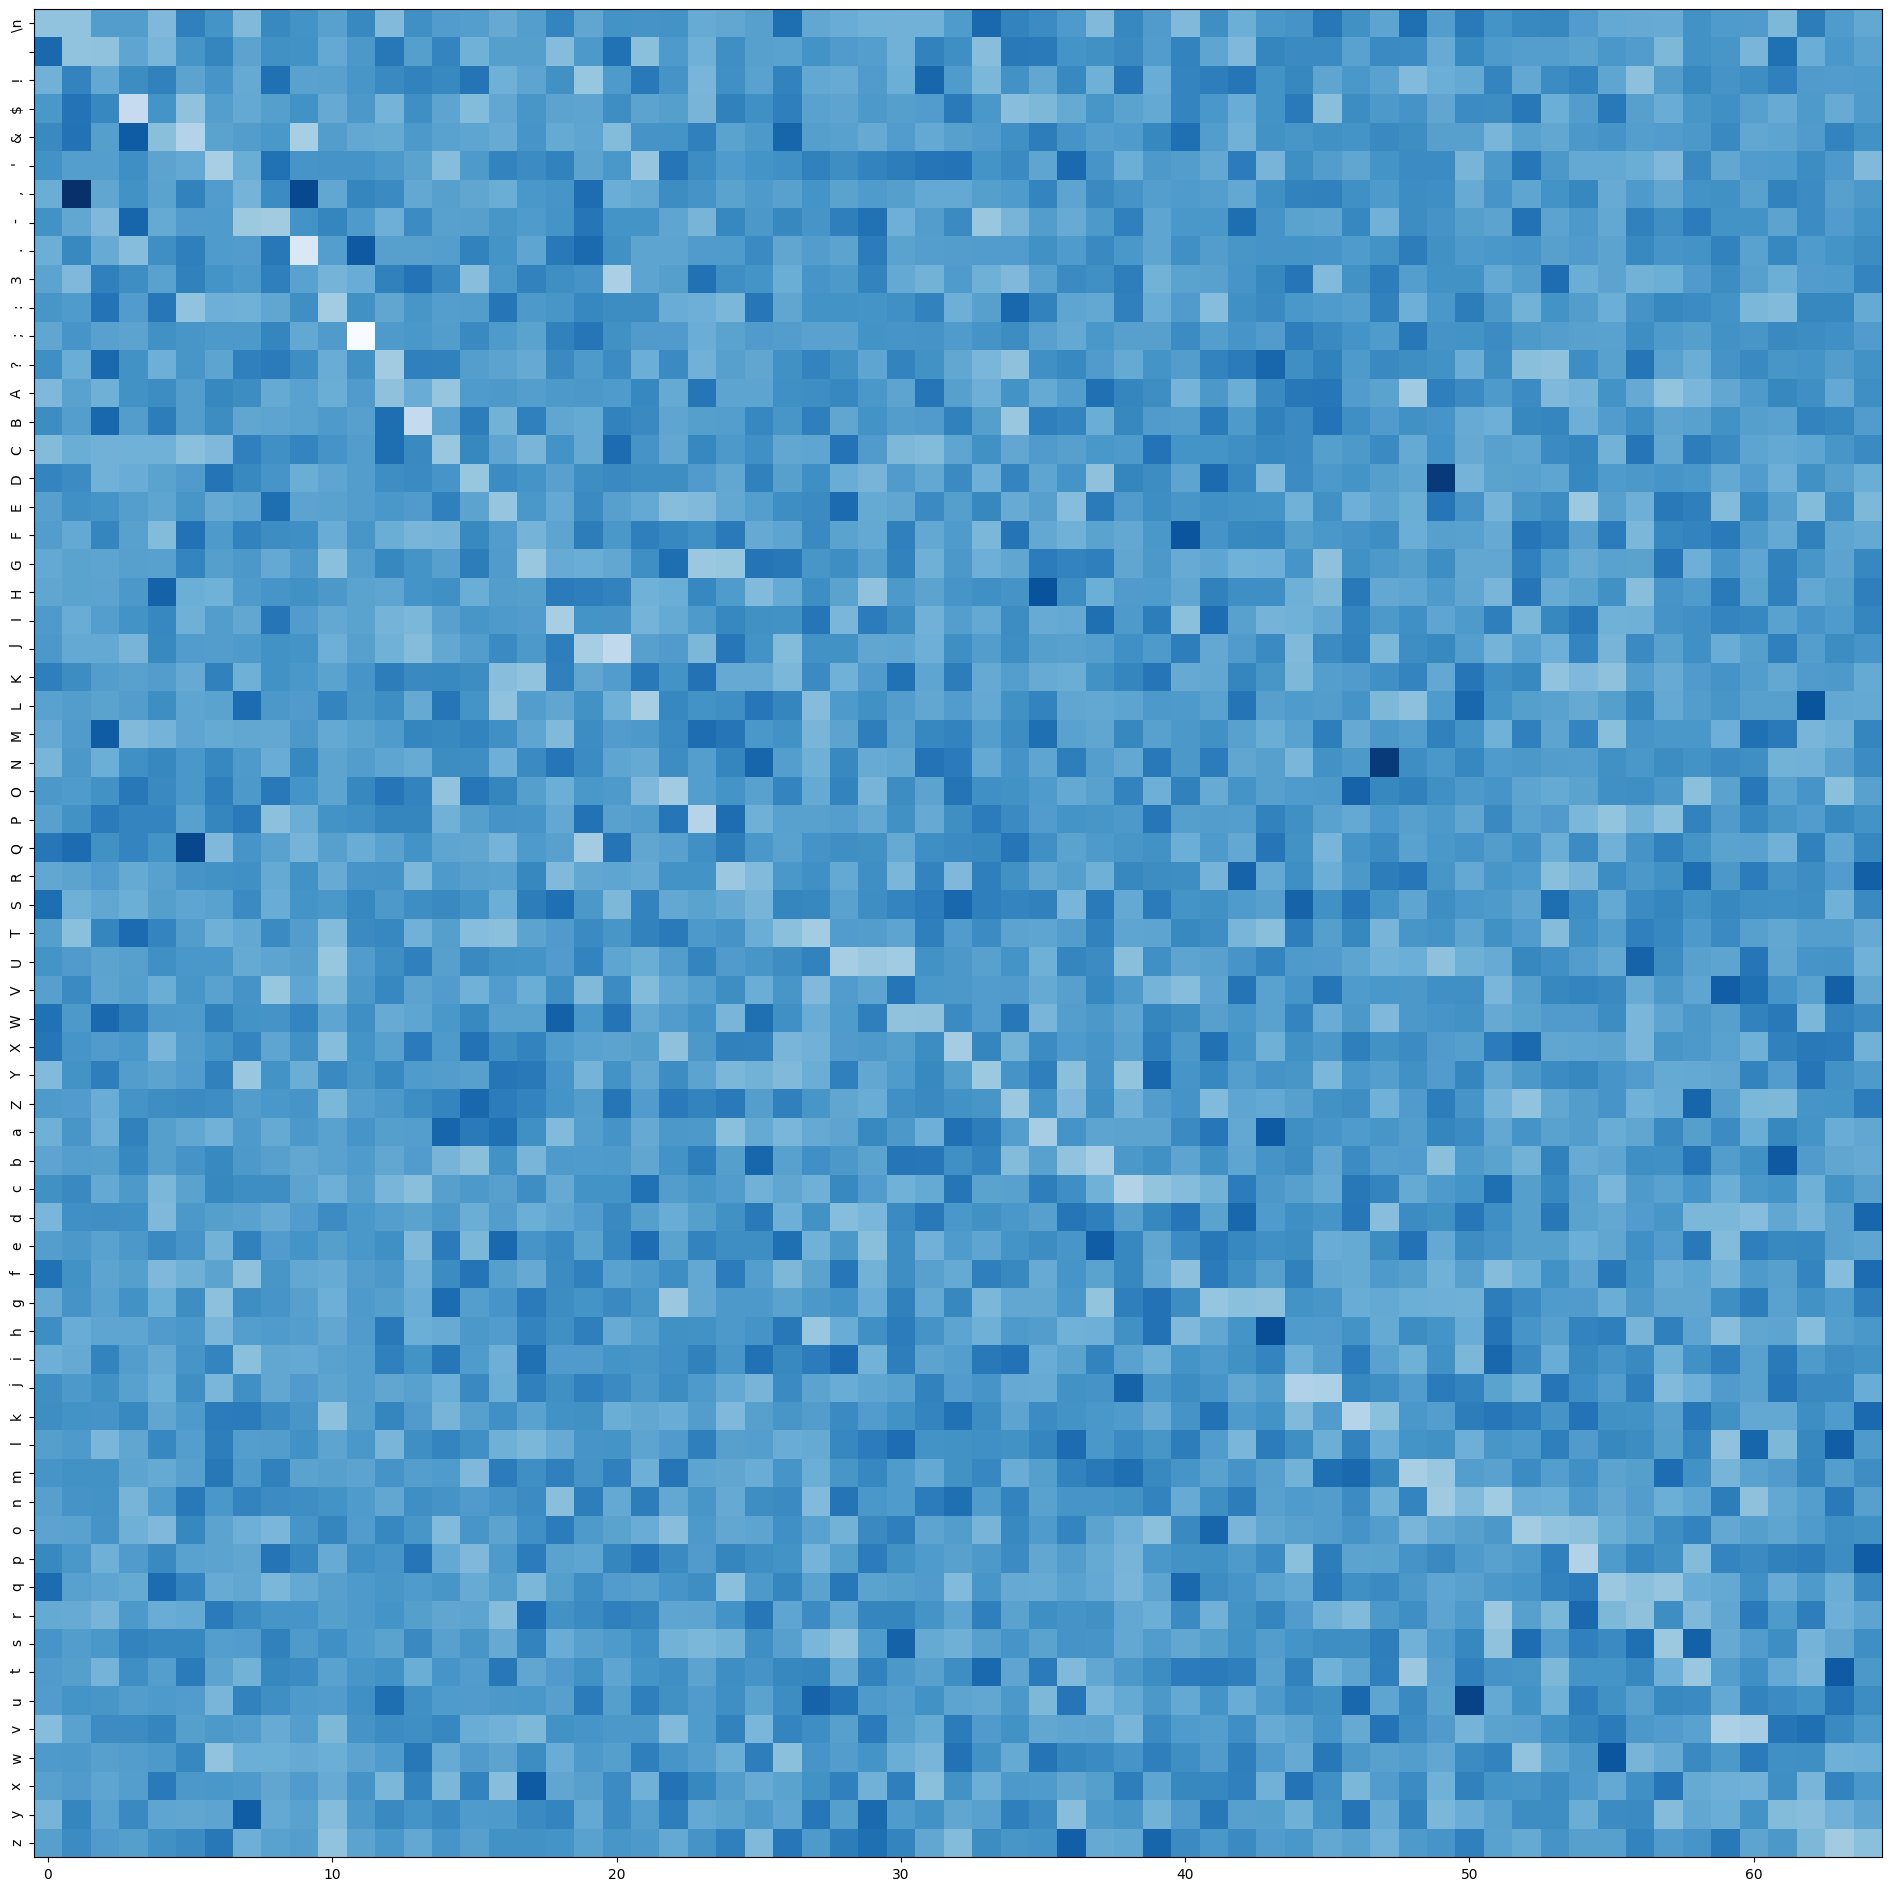

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
im = ax.imshow(U_inorder.detach().numpy(), cmap='Blues_r', interpolation='none')

char_labels = [repr(c)[1:-1] for c in chars]
ax.set_yticks(range(vocab_size))
ax.set_yticklabels(char_labels, rotation='vertical')